In [8]:
# ==========================================
# STEP 1: ACTIVATION FUNCTIONS
# ==========================================

# class ReLU:
#     """
#     Rectified Linear Unit activation function.
#     f(x) = max(0, x)
#     f'(x) = 1 if x > 0, else 0
#     """
    
#     def __init__(self):
#         """Initialize ReLU activation."""
#         self.last_input = None
    
#     def forward(self, x):
#         """
#         Forward pass: f(x) = max(0, x)
        
#         Args:
#             x (numpy.ndarray): Input array
            
#         Returns:
#             numpy.ndarray: Output after ReLU activation
#         """
#         self.last_input = x.copy()  # Store for backward pass
#         return np.maximum(0, x)
    
#     def backward(self, grad_output):
#         """
#         Backward pass: derivative of ReLU
#         f'(x) = 1 if x > 0, else 0
        
#         Args:
#             grad_output (numpy.ndarray): Gradient from subsequent layer
            
#         Returns:
#             numpy.ndarray: Gradient with respect to input
#         """
#         grad_input = grad_output.copy()
#         grad_input[self.last_input <= 0] = 0  # Zero gradient where input was <= 0
#         return grad_input

class ReLU:
    """
    Rectified Linear Unit activation function.
    f(x) = max(0, x)
    f'(x) = 1 if x > 0, else 0
    """
    
    def __init__(self):
        """Initialize ReLU activation."""
        self.last_input = None
    
    def forward(self, x):
        """
        Forward pass: f(x) = max(0, x)
        
        Args:
            x (numpy.ndarray): Input array
            
        Returns:
            numpy.ndarray: Output after ReLU activation
        """
        self.last_input = x  # Store reference, not copy (to save memory)
        return np.maximum(0, x)
    
    def backward(self, grad_output):
        """
        Backward pass: derivative of ReLU
        f'(x) = 1 if x > 0, else 0
        
        Args:
            grad_output (numpy.ndarray): Gradient from subsequent layer
            
        Returns:
            numpy.ndarray: Gradient with respect to input
        """
        # Create mask where input > 0
        mask = (self.last_input > 0).astype(float)
        
        # Gradient = grad_output * mask
        grad_input = grad_output * mask
        
        return grad_input
class Tanh:
    """
    Hyperbolic tangent activation function.
    f(x) = tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))
    f'(x) = 1 - tanh^2(x)
    """
    
    def __init__(self):
        """Initialize Tanh activation."""
        self.last_output = None
    
    def forward(self, x):
        """
        Forward pass: f(x) = tanh(x)
        
        Args:
            x (numpy.ndarray): Input array
            
        Returns:
            numpy.ndarray: Output after Tanh activation
        """
        self.last_output = np.tanh(x)
        return self.last_output
    
    def backward(self, grad_output):
        """
        Backward pass: derivative of Tanh
        f'(x) = 1 - tanh^2(x)
        
        Args:
            grad_output (numpy.ndarray): Gradient from subsequent layer
            
        Returns:
            numpy.ndarray: Gradient with respect to input
        """
        return grad_output * (1 - self.last_output ** 2)

class Sigmoid:
    """
    Sigmoid activation function.
    f(x) = 1 / (1 + e^(-x))
    f'(x) = sigmoid(x) * (1 - sigmoid(x))
    """
    
    def __init__(self):
        """Initialize Sigmoid activation."""
        self.last_output = None
    
    def forward(self, x):
        """
        Forward pass: f(x) = 1 / (1 + e^(-x))
        
        Args:
            x (numpy.ndarray): Input array
            
        Returns:
            numpy.ndarray: Output after Sigmoid activation
        """
        # Clip x to prevent overflow in exp(-x)
        x_clipped = np.clip(x, -500, 500)
        self.last_output = 1 / (1 + np.exp(-x_clipped))
        return self.last_output
    
    def backward(self, grad_output):
        """
        Backward pass: derivative of Sigmoid
        f'(x) = sigmoid(x) * (1 - sigmoid(x))
        
        Args:
            grad_output (numpy.ndarray): Gradient from subsequent layer
            
        Returns:
            numpy.ndarray: Gradient with respect to input
        """
        return grad_output * self.last_output * (1 - self.last_output)

class Identity:
    """
    Identity activation function (no activation).
    f(x) = x
    f'(x) = 1
    """
    
    def __init__(self):
        """Initialize Identity activation."""
        pass
    
    def forward(self, x):
        """
        Forward pass: f(x) = x
        
        Args:
            x (numpy.ndarray): Input array
            
        Returns:
            numpy.ndarray: Input unchanged
        """
        return x
    
    def backward(self, grad_output):
        """
        Backward pass: derivative of Identity
        f'(x) = 1
        
        Args:
            grad_output (numpy.ndarray): Gradient from subsequent layer
            
        Returns:
            numpy.ndarray: Gradient unchanged
        """
        return grad_output




In [9]:
# ==========================================
# STEP 2: LINEAR LAYER
# ==========================================

class Linear:
    """
    Linear (fully connected) layer with weights, biases, and activation.
    
    Implements: output = activation(input @ weights + bias)
    """
    
    def __init__(self, input_size, output_size, activation=None):
        """
        Initialize the linear layer.
        
        Args:
            input_size (int): Number of input features
            output_size (int): Number of output features  
            activation: Activation function object (ReLU, Tanh, Sigmoid, Identity)
        """
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation if activation is not None else Identity()
        
        # Initialize weights using Xavier/Glorot initialization - Weights are initialized randomly. The formula used here is called Xavier/Glorot initialization — it keeps the variance of outputs reasonable so gradients don’t vanish or explode.
        # This helps with gradient flow in deep networks
        limit = np.sqrt(6.0 / (input_size + output_size))
        self.weights = np.random.uniform(-limit, limit, (input_size, output_size))
        self.bias = np.zeros((1, output_size)) # Biases start at zero.
        
        # Storage for forward pass (needed for backward pass)
        # These are placeholders to store values needed for backward pass.
        # During backpropagation, we need the original inputs and outputs to compute gradients.
        
        self.last_input = None # This will store the input x that was given to the layer during the forward pass.
        self.last_linear_output = None # This will store the output before activation → that is, the raw linear combination:z=XW+b 
        self.last_output = None # This will store the final output after the activation function is applied. y=activation(z) 
        
        # Gradient accumulation
        # When backpropagation runs, it will compute how much each weight and bias should be adjusted — that’s the gradient.
        # We initialize them to zero arrays of the same shape as the weights and biases so that we can accumulate gradients over multiple batches if needed. 
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_bias = np.zeros_like(self.bias)
        
        print(f"Linear layer created: {input_size} -> {output_size}, activation: {type(self.activation).__name__}")
    
    def forward(self, x):
        """
        Forward pass through the layer.
        
        Args:
            x (numpy.ndarray): Input of shape (batch_size, input_size)
            
        Returns:
            numpy.ndarray: Output of shape (batch_size, output_size)
        """
        # Store input for backward pass - We store a copy of the input so we can use it later during backpropagation. 
        self.last_input = x.copy()
        
        # Linear transformation: y = x @ W + b 
        self.last_linear_output = x @ self.weights + self.bias
        
        # Apply activation function
        self.last_output = self.activation.forward(self.last_linear_output)
        
        return self.last_output
    
    def backward(self, grad_output):
        """
        Backward pass through the layer.
        
        Args:
            grad_output (numpy.ndarray): Gradient from subsequent layer
            
        Returns:
            numpy.ndarray: Gradient with respect to input
        """
        # Get gradient from activation function
        grad_linear = self.activation.backward(grad_output)
        
        # Compute gradients for weights and bias
        # grad_weights = input^T @ grad_linear
        self.grad_weights += self.last_input.T @ grad_linear
        
        # grad_bias = sum(grad_linear, axis=0) (sum over batch dimension)
        self.grad_bias += np.sum(grad_linear, axis=0, keepdims=True)
        
        # Compute gradient with respect to input
        # grad_input = grad_linear @ weights^T
        grad_input = grad_linear @ self.weights.T
        
        return grad_input
    
    def zero_grad(self):
        """
        Reset accumulated gradients to zero.
        During training, every time we process a batch of data, we compute gradients for that batch.
        If we dont reset them, they will accumulate from previous batches — giving wrong results.
        """
        self.grad_weights.fill(0)
        self.grad_bias.fill(0)
    
    def update_weights(self, learning_rate):
        """
        Update weights and biases using accumulated gradients.
        
        Args:
            learning_rate (float): Learning rate for gradient descent
        """
        self.weights -= learning_rate * self.grad_weights
        self.bias -= learning_rate * self.grad_bias



In [10]:
# ==========================================
# STEP 3: LOSS FUNCTIONS
# ==========================================

class MSELoss:
    """
    Mean Squared Error loss function.
    
    L = (1/n) * sum((y_pred - y_true)^2)
    """
    
    def __init__(self):
        """Initialize MSE loss."""
        self.last_predictions = None
        self.last_targets = None
    
    def forward(self, predictions, targets):
        """
        Compute MSE loss.
        
        Args:
            predictions (numpy.ndarray): Predicted values
            targets (numpy.ndarray): True values
            
        Returns:
            float: MSE loss value
        """
        self.last_predictions = predictions.copy()
        self.last_targets = targets.copy()
        
        # Ensure targets have the same shape as predictions
        if targets.ndim == 1 and predictions.ndim == 2:
            targets = targets.reshape(-1, 1)
        
        # MSE = mean((y_pred - y_true)^2)
        loss = np.mean((predictions - targets) ** 2)
        return loss
    
    def backward(self):
        """
        Compute gradient of MSE loss.
        
        Returns:
            numpy.ndarray: Gradient with respect to predictions
        """
        # d/dy_pred MSE = 2 * (y_pred - y_true) / n
        targets = self.last_targets
        if targets.ndim == 1 and self.last_predictions.ndim == 2:
            targets = targets.reshape(-1, 1)
            
        grad = 2.0 * (self.last_predictions - targets) / self.last_predictions.shape[0]
        return grad

class BCELoss:
    """
    Binary Cross Entropy loss function.
    
    L = -(1/n) * sum(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
    """
    
    def __init__(self):
        """Initialize BCE loss."""
        self.last_predictions = None
        self.last_targets = None
    
    def forward(self, predictions, targets):
        """
        Compute BCE loss.
        
        Args:
            predictions (numpy.ndarray): Predicted probabilities [0, 1]
            targets (numpy.ndarray): True binary labels {0, 1}
            
        Returns:
            float: BCE loss value
        """
        self.last_predictions = predictions.copy()
        self.last_targets = targets.copy()
        
        # Ensure targets have the same shape as predictions
        if targets.ndim == 1 and predictions.ndim == 2:
            targets = targets.reshape(-1, 1)
        
        # Clip predictions to prevent log(0)
        eps = 1e-15
        predictions_clipped = np.clip(predictions, eps, 1 - eps)
        
        # BCE = -mean(y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
        loss = -np.mean(targets * np.log(predictions_clipped) + 
                       (1 - targets) * np.log(1 - predictions_clipped))
        return loss
    
    def backward(self):
        """
        Compute gradient of BCE loss.
        
        Returns:
            numpy.ndarray: Gradient with respect to predictions
        """
        targets = self.last_targets
        if targets.ndim == 1 and self.last_predictions.ndim == 2:
            targets = targets.reshape(-1, 1)
        
        # Clip predictions to prevent division by 0
        eps = 1e-15
        predictions_clipped = np.clip(self.last_predictions, eps, 1 - eps)
        
        # d/dy_pred BCE = -(y_true/y_pred - (1-y_true)/(1-y_pred)) / n
        grad = -(targets / predictions_clipped - 
                (1 - targets) / (1 - predictions_clipped)) / self.last_predictions.shape[0]
        return grad



In [11]:
# ==========================================
# STEP 4: MODEL CLASS
# ==========================================

class Model:
    """
    Neural Network Model class that combines layers and handles training.
    """
    
    def __init__(self, layers, loss_function, learning_rate=0.01):
        """
        Initialize the model.
        
        Args:
            layers (list): List of Linear layer objects
            loss_function: Loss function object (MSELoss or BCELoss)
            learning_rate (float): Learning rate for optimization
        """
        self.layers = layers # keeps a reference to all network layers so the model can loop over them for forward and backward passes.
        self.loss_function = loss_function # keeps a reference to the loss function object to compute loss and its gradient.
        self.learning_rate = learning_rate # stored so that when we update weights, we know how big the step is.
        
        # Training history
        self.train_losses = [] # list to store loss values for each training step (so we can plot or monitor learning).
        self.samples_seen = [] # optional, can track how many samples the model has seen if you want to monitor progress.
        
        print(f"Model created with {len(layers)} layers:")
        for i, layer in enumerate(layers): 
            if hasattr(layer, 'input_size') and hasattr(layer, 'output_size'):
                # This is a Linear layer
                print(f"  Layer {i+1}: Linear({layer.input_size} -> {layer.output_size}, {type(layer.activation).__name__})")
            else:
                # This is an activation function
                print(f"  Layer {i+1}: {type(layer).__name__}")
        print(f"Loss function: {type(loss_function).__name__}")
        print(f"Learning rate: {learning_rate}")
    
    def forward(self, x):
        """
        Forward pass through all layers.
        
        Args:
            x (numpy.ndarray): Input data
            
        Returns:
            numpy.ndarray: Model predictions
        """
        output = x # The input x (a NumPy array of shape (batch_size, input_features)) is assigned to output. This will propagate through all layers.
        for i, layer in enumerate(self.layers):
            output = layer.forward(output) # The output of one layer becomes the input for the next layer.
            # print(f"  Layer {i+1} output (after activation):\n{output}")
        return output # After passing through all layers, the final output is the model’s prediction (y_pred).
    
    def backward(self, loss_grad):
        """
        Backward pass through all layers.
        
        Args:
            loss_grad (numpy.ndarray): Gradient from loss function
        """
        grad = loss_grad # loss_grad is the derivative of the loss function with respect to the model’s predictions (dL/dy_pred). Example: if using MSE: grad = 2*(y_pred - y_true)/n
        
        for idx, layer in enumerate(reversed(self.layers)): # Backpropagation works backward from the output layer to the input layer.
            # For each layer:
            # layer.backward(grad) computes:
            # Gradient w.r.t weights: dL/dW
            # Gradient w.r.t bias: dL/db
            # Gradient w.r.t input: dL/dx to pass to the previous layer
            # Updates the cumulative gradients stored in the layer.
            # Returns grad for the next layer backward.
            grad = layer.backward(grad)
            layer_num = len(self.layers) - idx  
            # print(f"  Layer {layer_num} gradients:")
            # print(f"    grad_weights:\n{layer.grad_weights}") # Weight gradients (dL/dW)
            # print(f"    grad_bias:\n{layer.grad_bias}") # Bias gradients (dL/db)
            # print(f"    grad_input (to pass to previous layer):\n{grad}")

    def train_step(self, x, y):
        """
        Perform one training step (forward + backward + accumulate gradients).
        
        Args:
            x (numpy.ndarray): Input data
            y (numpy.ndarray): Target data
            
        Returns:
            float: Loss value for this step
        """
        # Forward pass
        predictions = self.forward(x)
        
        # Compute loss
        loss = self.loss_function.forward(predictions, y)
        
        # Backward pass
        loss_grad = self.loss_function.backward()
        self.backward(loss_grad)
        
        return loss
    
    def zero_grad(self):
        """Reset gradients in all layers."""
        for layer in self.layers:
            layer.zero_grad()
    
    def update_weights(self):
        """Update weights in all layers and reset gradients."""
        for layer in self.layers:
            layer.update_weights(self.learning_rate)
        self.zero_grad()
    
    def predict(self, x):
        """
        Make predictions without training.
        
        Args:
            x (numpy.ndarray): Input data
            
        Returns:
            numpy.ndarray: Model predictions
        """
        return self.forward(x)
    
    def save_to(self, path):
        """
        Save model parameters to file.
        
        Args:
            path (str): File path to save to
        """
        save_dict = {} # Create an empty dictionary to store everything we want to save.
        
        # Save layer parameters
        for i, layer in enumerate(self.layers):
            save_dict[f'layer_{i}_weights'] = layer.weights 
            save_dict[f'layer_{i}_bias'] = layer.bias
            save_dict[f'layer_{i}_input_size'] = layer.input_size
            save_dict[f'layer_{i}_output_size'] = layer.output_size
            save_dict[f'layer_{i}_activation'] = type(layer.activation).__name__
        
        # Save model metadata
        save_dict['num_layers'] = len(self.layers)
        save_dict['learning_rate'] = self.learning_rate
        save_dict['loss_function'] = type(self.loss_function).__name__
        
        np.savez(path, **save_dict)
        print(f"Model saved to {path}")
    
    def load_from(self, path):
        """
        Load model parameters from file.
        
        Args:
            path (str): File path to load from
        """
        data = np.load(path, allow_pickle=True)
        
        # Verify architecture matches # Prevents accidentally loading weights into the wrong architecture.
        if data['num_layers'] != len(self.layers):
            raise ValueError(f"Architecture mismatch: saved model has {data['num_layers']} layers, "
                           f"current model has {len(self.layers)} layers")
        
        # Load layer parameters
        # For each layer:
        # Load the saved weights and bias.
        # Check if the shapes match the current model’s layers.
        # If not → raise an error (prevents crashes).
        # Copy the values into the current model’s layers.
        for i, layer in enumerate(self.layers):
            # Check dimensions match
            saved_weights = data[f'layer_{i}_weights']
            if saved_weights.shape != layer.weights.shape:
                raise ValueError(f"Weight shape mismatch in layer {i}: "
                               f"saved {saved_weights.shape}, current {layer.weights.shape}")
            
            saved_bias = data[f'layer_{i}_bias']
            if saved_bias.shape != layer.bias.shape:
                raise ValueError(f"Bias shape mismatch in layer {i}: "
                               f"saved {saved_bias.shape}, current {layer.bias.shape}")
            
            # Load parameters
            layer.weights = saved_weights.copy()
            layer.bias = saved_bias.copy()
        
        print(f"Model loaded from {path}")
        print(f"Architecture verified: {len(self.layers)} layers match")




# Question 2: Feature Mappings for Image Reconstruction [30 Marks]

## Overview

This question explores how different input feature representations affect neural network performance in image reconstruction tasks. Based on the research by Tancik et al. (2020), we'll compare three feature mapping approaches:

### **Key Concepts from the Research Paper:**

1. **Spectral Bias Problem**: Neural networks have an inherent bias toward learning low-frequency functions first
2. **Fourier Feature Solution**: Mapping inputs through sinusoidal functions enables learning high-frequency details
3. **Coordinate-based MLPs**: Using (x,y) coordinates as inputs to predict pixel values

### **Three Feature Mappings to Compare:**

1. **Raw Mapping**: γ_raw(x,y) = (x,y) - Direct coordinate usage
2. **Polynomial Mapping**: γ_poly(x,y) = [x, y, x², y², xy, ..., x^k, y^k] - Taylor-inspired basis
3. **Fourier Mapping**: γ_fourier(x,y) = [1, sin(2πf₁x), cos(2πf₁x), ..., sin(2πf₁y), cos(2πf₁y)] - Sinusoidal embedding

### **Tasks:**
- **Part 2.1**: Setup and load images (smiley.png, cat.jpg)
- **Part 2.2**: Implement the three feature expansion methods
- **Part 2.3**: Create modular data loader with proper normalization
- **Part 2.4**: Training comparison and visualization with GIFs
- **Part 2.5**: Reconstruction on blurred images (blur levels σ=0 to 10)

PART 2.1: SETUP AND IMAGE LOADING

[1] Loading smiley.png (grayscale)...
✓ Image loaded successfully:
  Path: Q2-20251008T082436Z-1-001/Q2/smiley.png
  Type: Gray
  Size: (256, 256)
  Value range: [0.000, 1.000]

[2] Loading cat.jpg (RGB)...
✓ Image loaded successfully:
  Path: Q2-20251008T082436Z-1-001/Q2/cat.jpg
  Type: RGB
  Size: (256, 256, 3)
  Value range: [0.000, 1.000]

[3] Visualizing loaded images...


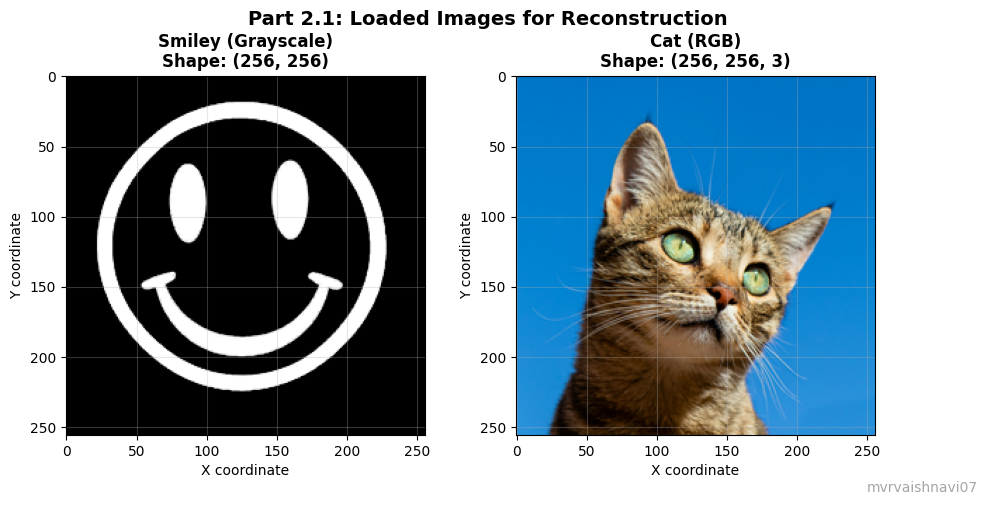


✓ Part 2.1 Complete: Images loaded and visualized successfully!


In [12]:
# ==========================================
# PART 2.1: SETUP AND VISUALIZATION [4 MARKS]
# ==========================================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

class ImageLoader:
    """
    Utility class for loading and preprocessing images for coordinate-based MLP training.
    """
    
    def __init__(self, username="mvrvaishnavi07"):
        """Initialize ImageLoader with username for watermarks."""
        self.username = username
    
    def load_image(self, image_path, target_size=(256, 256), image_type="RGB"):
        """
        Load and preprocess an image.
        
        Args:
            image_path (str): Path to the image file
            target_size (tuple): Target size (width, height)
            image_type (str): "RGB" or "Gray"
            
        Returns:
            numpy.ndarray: Processed image array
        """
        try:
            # Load image
            img = Image.open(image_path)
            
            # Convert to specified type
            if image_type == "Gray":
                img = img.convert('L')  # Convert to grayscale
            elif image_type == "RGB":
                img = img.convert('RGB')
            else:
                raise ValueError("image_type must be 'RGB' or 'Gray'")
            
            # Resize to target size
            img = img.resize(target_size, Image.Resampling.LANCZOS)
            
            # Convert to numpy array and normalize to [0, 1]
            img_array = np.array(img, dtype=np.float32) / 255.0
            
            print(f"✓ Image loaded successfully:")
            print(f"  Path: {image_path}")
            print(f"  Type: {image_type}")
            print(f"  Size: {img_array.shape}")
            print(f"  Value range: [{img_array.min():.3f}, {img_array.max():.3f}]")
            
            return img_array
            
        except Exception as e:
            print(f"❌ Error loading image {image_path}: {e}")
            return None
    
    def create_coordinate_grid(self, height, width):
        """
        Create normalized coordinate grid for the image.
        
        Args:
            height (int): Image height
            width (int): Image width
            
        Returns:
            numpy.ndarray: Coordinate array of shape (height*width, 2)
        """
        # Create coordinate meshgrid
        y_coords, x_coords = np.meshgrid(
            np.linspace(0, 1, height),  # Normalize to [0, 1]
            np.linspace(0, 1, width),
            indexing='ij'
        )
        
        # Flatten and stack coordinates
        coords = np.stack([x_coords.flatten(), y_coords.flatten()], axis=1)
        
        print(f"✓ Coordinate grid created:")
        print(f"  Shape: {coords.shape}")
        print(f"  X range: [{coords[:, 0].min():.3f}, {coords[:, 0].max():.3f}]")
        print(f"  Y range: [{coords[:, 1].min():.3f}, {coords[:, 1].max():.3f}]")
        
        return coords
    
    def prepare_training_data(self, image_array, coords):
        """
        Prepare training data from image and coordinates.
        
        Args:
            image_array (numpy.ndarray): Image array
            coords (numpy.ndarray): Coordinate array
            
        Returns:
            tuple: (coordinates, pixel_values)
        """
        # Flatten image to get pixel values
        if len(image_array.shape) == 3:  # RGB
            pixel_values = image_array.reshape(-1, image_array.shape[2])
        else:  # Grayscale
            pixel_values = image_array.flatten().reshape(-1, 1)
        
        print(f"✓ Training data prepared:")
        print(f"  Coordinates shape: {coords.shape}")
        print(f"  Pixel values shape: {pixel_values.shape}")
        print(f"  Total samples: {len(coords)}")
        
        return coords, pixel_values
    
    def visualize_images(self, images_dict, title="Loaded Images"):
        """
        Visualize multiple images side by side.
        
        Args:
            images_dict (dict): Dictionary of {name: image_array}
            title (str): Plot title
        """
        n_images = len(images_dict)
        fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))
        
        if n_images == 1:
            axes = [axes]
        
        for idx, (name, img_array) in enumerate(images_dict.items()):
            ax = axes[idx]
            
            if len(img_array.shape) == 2:  # Grayscale
                ax.imshow(img_array, cmap='gray', vmin=0, vmax=1)
            else:  # RGB
                ax.imshow(img_array)
            
            ax.set_title(f'{name}\nShape: {img_array.shape}', fontsize=12, fontweight='bold')
            ax.set_xlabel('X coordinate')
            ax.set_ylabel('Y coordinate')
            ax.grid(True, alpha=0.3)
        
        plt.suptitle(title, fontsize=14, fontweight='bold')
        
        # Add username watermark
        plt.text(0.99, 0.01, self.username,
                ha='right', va='bottom', transform=fig.transFigure,
                fontsize=10, color='gray', alpha=0.7)
        
        plt.tight_layout()
        plt.show()

# Initialize image loader
print("="*70)
print("PART 2.1: SETUP AND IMAGE LOADING")
print("="*70)

image_loader = ImageLoader(username="mvrvaishnavi07")

# Load the images
print("\n[1] Loading smiley.png (grayscale)...")
smiley_path = "Q2-20251008T082436Z-1-001/Q2/smiley.png"
smiley_img = image_loader.load_image(smiley_path, target_size=(256, 256), image_type="Gray")

print("\n[2] Loading cat.jpg (RGB)...")
cat_path = "Q2-20251008T082436Z-1-001/Q2/cat.jpg"
cat_img = image_loader.load_image(cat_path, target_size=(256, 256), image_type="RGB")

# Visualize loaded images
if smiley_img is not None and cat_img is not None:
    print("\n[3] Visualizing loaded images...")
    images_dict = {
        'Smiley (Grayscale)': smiley_img,
        'Cat (RGB)': cat_img
    }
    image_loader.visualize_images(images_dict, "Part 2.1: Loaded Images for Reconstruction")
    
    print("\n✓ Part 2.1 Complete: Images loaded and visualized successfully!")
else:
    print("\n❌ Failed to load images. Please check file paths.")

print("="*70)

PART 2.2: FEATURE EXPANSION IMPLEMENTATIONS

[1] Creating sample coordinate grid...
✓ Coordinate grid created:
  Shape: (65536, 2)
  X range: [0.000, 1.000]
  Y range: [0.000, 1.000]
Using 66 coordinates for demonstration

[2] Demonstrating feature mappings...
🔍 DEMONSTRATING FEATURE MAPPINGS
Using 66 sample coordinates

📊 RAW FEATURES:
   Input shape: (66, 2)
   Output shape: (66, 2)
   Feature count: 2
   Value range: [0.000, 0.992]

📊 POLYNOMIAL FEATURES:
   Order  5:  20 features, range: [0.000, 0.992]
   Order 15: 135 features, range: [0.000, 0.992]
   Order 25: 350 features, range: [0.000, 0.992]

📊 FOURIER FEATURES:
   Freq  5:  21 features, range: [-1.000, 1.000]
   Freq 15:  61 features, range: [-1.000, 1.000]
   Freq 25: 101 features, range: [-1.000, 1.000]



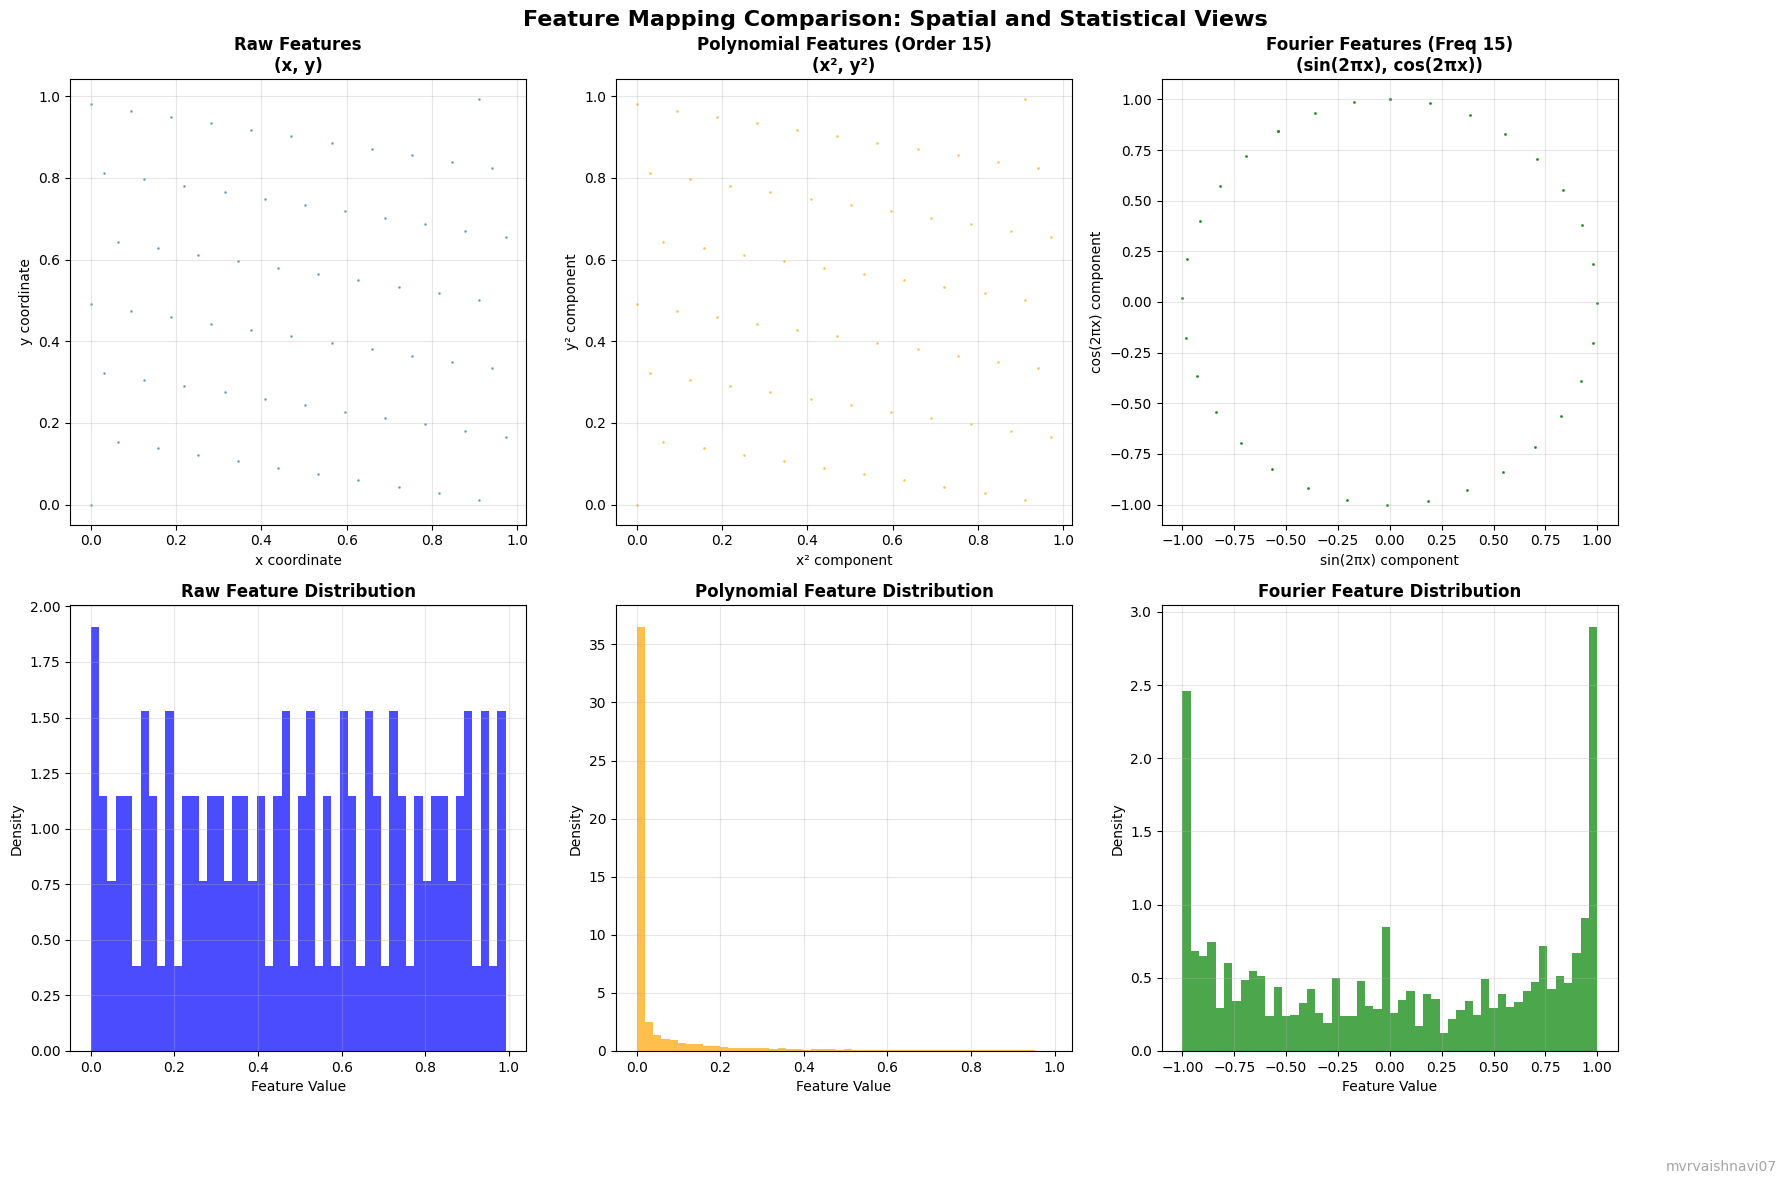


✓ Part 2.2 Complete: Feature expansions implemented and demonstrated!


In [13]:
# ==========================================
# PART 2.2: FEATURE EXPANSIONS [9 MARKS]
# ==========================================

class FeatureMapper:
    """
    Implementation of different feature mapping strategies for coordinate-based MLPs.
    Based on Tancik et al. (2020) - Fourier Features Let Networks Learn High Frequency Functions.
    """
    
    def __init__(self, username="mvrvaishnavi07"):
        """Initialize FeatureMapper."""
        self.username = username
    
    def get_raw(self, coords):
        """
        Raw coordinate mapping: γ_raw(x,y) = (x,y)
        
        This is the baseline approach where coordinates are used directly.
        According to the paper, this leads to spectral bias - networks prefer 
        learning low-frequency functions.
        
        Args:
            coords (numpy.ndarray): Input coordinates of shape (N, 2)
            
        Returns:
            numpy.ndarray: Raw coordinates (unchanged)
        """
        return coords.copy()
    
    def get_polynomial(self, coords, order=5):
        """
        Polynomial feature expansion: γ_poly(x,y) = [x, y, x², y², xy, ..., x^k, y^k]
        
        This Taylor-inspired expansion provides higher-order polynomial basis functions.
        It allows the network to represent nonlinear relationships between coordinates
        without explicit derivative computation.
        
        Args:
            coords (numpy.ndarray): Input coordinates of shape (N, 2)
            order (int): Maximum polynomial order
            
        Returns:
            numpy.ndarray: Polynomial features of shape (N, num_features)
        """
        x, y = coords[:, 0], coords[:, 1]
        features = []
        
        # Add all polynomial terms up to specified order
        for i in range(1, order + 1):
            for j in range(i + 1):
                # Add x^(i-j) * y^j terms
                x_power = i - j
                y_power = j
                
                if x_power == 0 and y_power == 0:
                    continue  # Skip constant term
                
                feature = (x ** x_power) * (y ** y_power)
                features.append(feature)
        
        # Stack all features
        polynomial_features = np.column_stack(features)
        
        return polynomial_features
    
    def get_fourier(self, coords, freq=10):
        """
        Fourier feature expansion: γ_fourier(x,y) = [1, sin(2πf₁x), cos(2πf₁x), ..., sin(2πf₁y), cos(2πf₁y)]
        
        This implements the key insight from Tancik et al.: mapping coordinates through
        sinusoidal functions enables networks to learn high-frequency details.
        
        To avoid combinatorial explosion of cross-terms, we compute sinusoidal embeddings
        for each coordinate independently and stack them.
        
        Args:
            coords (numpy.ndarray): Input coordinates of shape (N, 2)
            freq (int): Number of frequency components
            
        Returns:
            numpy.ndarray: Fourier features of shape (N, 1 + 4*freq)
        """
        x, y = coords[:, 0], coords[:, 1]
        features = []
        
        # Add constant term (DC component)
        features.append(np.ones_like(x))
        
        # Add sinusoidal features for x coordinate
        for f in range(1, freq + 1):
            features.append(np.sin(2 * np.pi * f * x))
            features.append(np.cos(2 * np.pi * f * x))
        
        # Add sinusoidal features for y coordinate
        for f in range(1, freq + 1):
            features.append(np.sin(2 * np.pi * f * y))
            features.append(np.cos(2 * np.pi * f * y))
        
        # Stack all features
        fourier_features = np.column_stack(features)
        
        return fourier_features
    
    def normalize_features(self, features, method="standard"):
        """
        Normalize features to prevent scale issues during training.
        
        Args:
            features (numpy.ndarray): Input features
            method (str): Normalization method ("standard", "minmax", "none")
            
        Returns:
            tuple: (normalized_features, normalization_stats)
        """
        if method == "none":
            return features, {}
        
        if method == "standard":
            # Z-score normalization: (x - μ) / σ
            mean = np.mean(features, axis=0)
            std = np.std(features, axis=0)
            std[std == 0] = 1  # Avoid division by zero
            normalized = (features - mean) / std
            stats = {'mean': mean, 'std': std, 'method': 'standard'}
            
        elif method == "minmax":
            # Min-max normalization: (x - min) / (max - min)
            min_val = np.min(features, axis=0)
            max_val = np.max(features, axis=0)
            range_val = max_val - min_val
            range_val[range_val == 0] = 1  # Avoid division by zero
            normalized = (features - min_val) / range_val
            stats = {'min': min_val, 'max': max_val, 'method': 'minmax'}
            
        else:
            raise ValueError(f"Unknown normalization method: {method}")
        
        return normalized, stats
    
    def demonstrate_feature_mappings(self, sample_coords, orders=[5, 15, 25], freqs=[5, 15, 25]):
        """
        Demonstrate and compare different feature mappings.
        
        Args:
            sample_coords (numpy.ndarray): Sample coordinates for demonstration
            orders (list): Polynomial orders to test
            freqs (list): Fourier frequencies to test
        """
        print("🔍 DEMONSTRATING FEATURE MAPPINGS")
        print("="*50)
        
        n_samples = len(sample_coords)
        print(f"Using {n_samples} sample coordinates\n")
        
        # 1. Raw features
        raw_features = self.get_raw(sample_coords)
        print(f"📊 RAW FEATURES:")
        print(f"   Input shape: {sample_coords.shape}")
        print(f"   Output shape: {raw_features.shape}")
        print(f"   Feature count: {raw_features.shape[1]}")
        print(f"   Value range: [{raw_features.min():.3f}, {raw_features.max():.3f}]")
        print()
        
        # 2. Polynomial features
        print(f"📊 POLYNOMIAL FEATURES:")
        for order in orders:
            poly_features = self.get_polynomial(sample_coords, order=order)
            print(f"   Order {order:2d}: {poly_features.shape[1]:3d} features, "
                  f"range: [{poly_features.min():.3f}, {poly_features.max():.3f}]")
        print()
        
        # 3. Fourier features
        print(f"📊 FOURIER FEATURES:")
        for freq in freqs:
            fourier_features = self.get_fourier(sample_coords, freq=freq)
            print(f"   Freq {freq:2d}: {fourier_features.shape[1]:3d} features, "
                  f"range: [{fourier_features.min():.3f}, {fourier_features.max():.3f}]")
        print()
        
        # 4. Visualization of feature distributions
        self.visualize_feature_distributions(sample_coords, orders[1], freqs[1])
    
    def visualize_feature_distributions(self, coords, poly_order=15, fourier_freq=15):
        """
        Visualize the distribution of different feature types.
        
        Args:
            coords (numpy.ndarray): Sample coordinates
            poly_order (int): Polynomial order for visualization
            fourier_freq (int): Fourier frequency for visualization
        """
        # Generate features
        raw_features = self.get_raw(coords)
        poly_features = self.get_polynomial(coords, order=poly_order)
        fourier_features = self.get_fourier(coords, freq=fourier_freq)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Raw features
        axes[0, 0].scatter(raw_features[:, 0], raw_features[:, 1], alpha=0.5, s=1)
        axes[0, 0].set_title('Raw Features\n(x, y)', fontweight='bold')
        axes[0, 0].set_xlabel('x coordinate')
        axes[0, 0].set_ylabel('y coordinate')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Polynomial features (first few components)
        if poly_features.shape[1] >= 2:
            axes[0, 1].scatter(poly_features[:, 0], poly_features[:, 1], alpha=0.5, s=1, c='orange')
            axes[0, 1].set_title(f'Polynomial Features (Order {poly_order})\n(x², y²)', fontweight='bold')
            axes[0, 1].set_xlabel('x² component')
            axes[0, 1].set_ylabel('y² component')
            axes[0, 1].grid(True, alpha=0.3)
        
        # Fourier features (first few components)
        if fourier_features.shape[1] >= 3:
            axes[0, 2].scatter(fourier_features[:, 1], fourier_features[:, 2], alpha=0.5, s=1, c='green')
            axes[0, 2].set_title(f'Fourier Features (Freq {fourier_freq})\n(sin(2πx), cos(2πx))', fontweight='bold')
            axes[0, 2].set_xlabel('sin(2πx) component')
            axes[0, 2].set_ylabel('cos(2πx) component')
            axes[0, 2].grid(True, alpha=0.3)
        
        # Feature value distributions
        axes[1, 0].hist(raw_features.flatten(), bins=50, alpha=0.7, color='blue', density=True)
        axes[1, 0].set_title('Raw Feature Distribution', fontweight='bold')
        axes[1, 0].set_xlabel('Feature Value')
        axes[1, 0].set_ylabel('Density')
        axes[1, 0].grid(True, alpha=0.3)
        
        axes[1, 1].hist(poly_features.flatten(), bins=50, alpha=0.7, color='orange', density=True)
        axes[1, 1].set_title(f'Polynomial Feature Distribution', fontweight='bold')
        axes[1, 1].set_xlabel('Feature Value')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].grid(True, alpha=0.3)
        
        axes[1, 2].hist(fourier_features.flatten(), bins=50, alpha=0.7, color='green', density=True)
        axes[1, 2].set_title(f'Fourier Feature Distribution', fontweight='bold')
        axes[1, 2].set_xlabel('Feature Value')
        axes[1, 2].set_ylabel('Density')
        axes[1, 2].grid(True, alpha=0.3)
        
        plt.suptitle('Feature Mapping Comparison: Spatial and Statistical Views', 
                    fontsize=16, fontweight='bold')
        
        # Add username watermark
        plt.text(0.99, 0.01, self.username,
                ha='right', va='bottom', transform=fig.transFigure,
                fontsize=10, color='gray', alpha=0.7)
        
        plt.tight_layout()
        plt.show()

# Initialize feature mapper and demonstrate
print("="*70)
print("PART 2.2: FEATURE EXPANSION IMPLEMENTATIONS")
print("="*70)

feature_mapper = FeatureMapper(username="mvrvaishnavi07")

# Create sample coordinates for demonstration
print("\n[1] Creating sample coordinate grid...")
if 'smiley_img' in locals() and smiley_img is not None:
    height, width = smiley_img.shape[:2]
    sample_coords = image_loader.create_coordinate_grid(height, width)
    
    # Use a subset for demonstration (to avoid overwhelming output)
    demo_coords = sample_coords[::1000]  # Every 1000th coordinate
    print(f"Using {len(demo_coords)} coordinates for demonstration")
    
    print("\n[2] Demonstrating feature mappings...")
    feature_mapper.demonstrate_feature_mappings(
        demo_coords, 
        orders=[5, 15, 25], 
        freqs=[5, 15, 25]
    )
    
    print("\n✓ Part 2.2 Complete: Feature expansions implemented and demonstrated!")
else:
    print("❌ No image loaded. Please run Part 2.1 first.")

print("="*70)

PART 2.3: MODULAR DATA LOADER TESTING

[1] Testing Raw features...
🔄 INITIALIZING MODULAR DATA LOADER
   Image: Q2-20251008T082436Z-1-001/Q2/smiley.png
   Type: Gray
   Method: Raw

✓ Image loaded successfully:
  Path: Q2-20251008T082436Z-1-001/Q2/smiley.png
  Type: Gray
  Size: (256, 256)
  Value range: [0.000, 1.000]
✓ Coordinate grid created:
  Shape: (65536, 2)
  X range: [0.000, 1.000]
  Y range: [0.000, 1.000]
✓ Training data prepared:
  Coordinates shape: (65536, 2)
  Pixel values shape: (65536, 1)
  Total samples: 65536
🎯 Applying Raw feature mapping...
   Features generated: (65536, 2)
   Value range: [0.000, 1.000]
🔧 Applying normalization...
   Raw features: No normalization needed (already in [0,1])
✓ Data loader initialized successfully!
   Final feature shape: (65536, 2)
   Pixel values shape: (65536, 1)


[2] Testing Polynomial features...
🔄 INITIALIZING MODULAR DATA LOADER
   Image: Q2-20251008T082436Z-1-001/Q2/smiley.png
   Type: Gray
   Method: Polynomial
   Order: 15

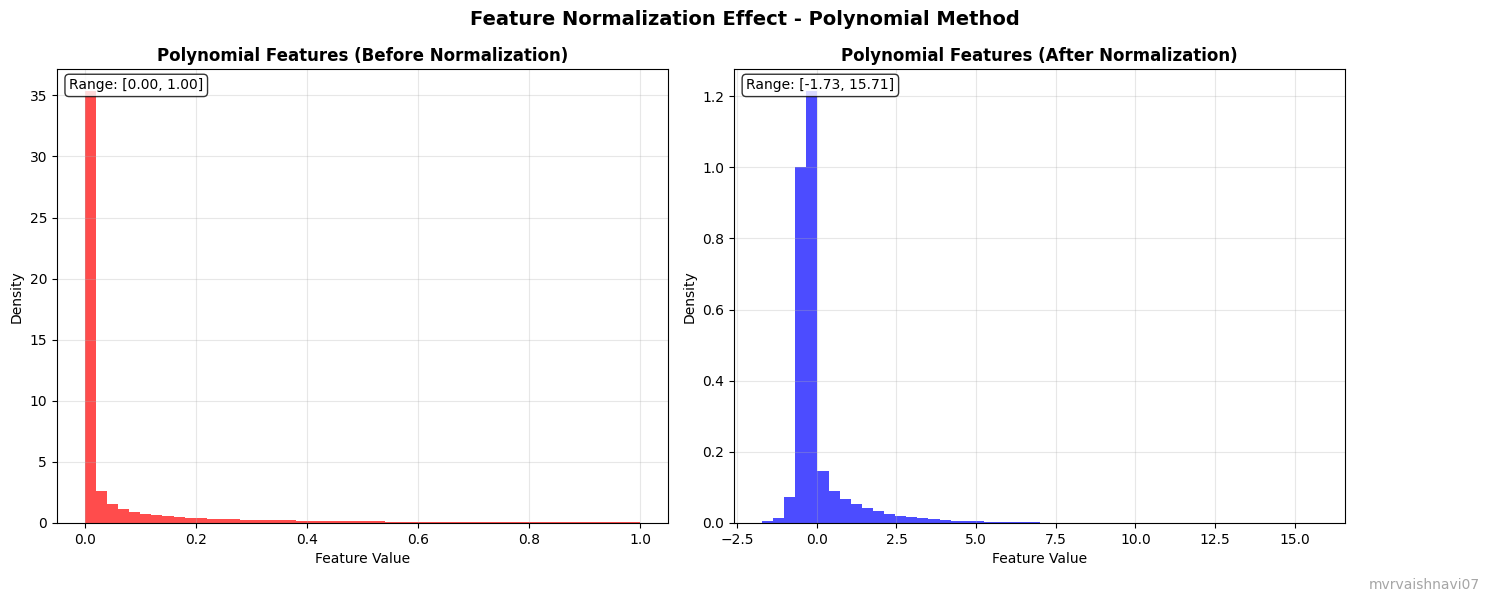


✓ Part 2.3 Complete: Modular data loader implemented and tested!


In [14]:
# ==========================================
# PART 2.3: NORMALIZATION AND MODULAR MLP [3 MARKS]
# ==========================================

class ModularDataLoader:
    """
    Modular data loader that handles different feature mappings with proper normalization.
    
    This addresses the key challenge that different feature expansions produce values
    on very different scales, which can strongly affect training stability and performance.
    """
    
    def __init__(self, img_path, image_type, method, order=None, freq=None, 
                 normalize=True, username="mvrvaishnavi07"):
        """
        Initialize modular data loader.
        
        Args:
            img_path (str): Path to the image file
            image_type (str): "RGB" or "Gray"
            method (str): Feature mapping method ("Raw", "Polynomial", "Fourier")
            order (int): Polynomial order (required if method="Polynomial")
            freq (int): Fourier frequency count (required if method="Fourier")
            normalize (bool): Whether to normalize features
            username (str): Username for watermarks
        """
        self.img_path = img_path
        self.image_type = image_type
        self.method = method
        self.order = order
        self.freq = freq
        self.normalize = normalize
        self.username = username
        
        # Initialize components
        self.image_loader = ImageLoader(username)
        self.feature_mapper = FeatureMapper(username)
        
        # Data storage
        self.image_array = None
        self.coordinates = None
        self.pixel_values = None
        self.features = None
        self.feature_stats = None
        
        # Load and process data
        self._load_and_process()
    
    def _load_and_process(self):
        """Load image and process features."""
        print(f"🔄 INITIALIZING MODULAR DATA LOADER")
        print(f"   Image: {self.img_path}")
        print(f"   Type: {self.image_type}")
        print(f"   Method: {self.method}")
        if self.method == "Polynomial":
            print(f"   Order: {self.order}")
        elif self.method == "Fourier":
            print(f"   Frequency: {self.freq}")
        print()
        
        # Load image
        self.image_array = self.image_loader.load_image(
            self.img_path, 
            target_size=(256, 256), 
            image_type=self.image_type
        )
        
        if self.image_array is None:
            raise ValueError(f"Failed to load image: {self.img_path}")
        
        # Create coordinate grid
        height, width = self.image_array.shape[:2]
        self.coordinates = self.image_loader.create_coordinate_grid(height, width)
        
        # Prepare pixel values
        _, self.pixel_values = self.image_loader.prepare_training_data(
            self.image_array, self.coordinates
        )
        
        # Apply feature mapping
        self._apply_feature_mapping()
        
        # Apply normalization if requested
        if self.normalize:
            self._apply_normalization()
        
        print(f"✓ Data loader initialized successfully!")
        print(f"   Final feature shape: {self.features.shape}")
        print(f"   Pixel values shape: {self.pixel_values.shape}")
        print()
    
    def _apply_feature_mapping(self):
        """Apply the specified feature mapping."""
        print(f"🎯 Applying {self.method} feature mapping...")
        
        if self.method == "Raw":
            self.features = self.feature_mapper.get_raw(self.coordinates)
            
        elif self.method == "Polynomial":
            if self.order is None:
                raise ValueError("order must be specified for Polynomial method")
            self.features = self.feature_mapper.get_polynomial(self.coordinates, self.order)
            
        elif self.method == "Fourier":
            if self.freq is None:
                raise ValueError("freq must be specified for Fourier method")
            self.features = self.feature_mapper.get_fourier(self.coordinates, self.freq)
            
        else:
            raise ValueError(f"Unknown method: {self.method}")
        
        print(f"   Features generated: {self.features.shape}")
        print(f"   Value range: [{self.features.min():.3f}, {self.features.max():.3f}]")
    
    def _apply_normalization(self):
        """Apply appropriate normalization based on feature type."""
        print(f"🔧 Applying normalization...")
        
        if self.method == "Raw":
            # Raw coordinates are already in [0, 1], no normalization needed
            self.feature_stats = {'method': 'none'}
            print("   Raw features: No normalization needed (already in [0,1])")
            
        elif self.method == "Polynomial":
            # Polynomial features can have very large values, use standard normalization
            self.features, self.feature_stats = self.feature_mapper.normalize_features(
                self.features, method="standard"
            )
            print("   Polynomial features: Applied z-score normalization")
            print(f"   Normalized range: [{self.features.min():.3f}, {self.features.max():.3f}]")
            
        elif self.method == "Fourier":
            # Fourier features are already in [-1, 1], but we can standardize for consistency
            self.features, self.feature_stats = self.feature_mapper.normalize_features(
                self.features, method="standard"
            )
            print("   Fourier features: Applied z-score normalization")
            print(f"   Normalized range: [{self.features.min():.3f}, {self.features.max():.3f}]")
    
    def get_data(self):
        """
        Get the processed training data.
        
        Returns:
            tuple: (features, pixel_values)
        """
        return self.features, self.pixel_values
    
    def get_info(self):
        """
        Get information about the loaded data.
        
        Returns:
            dict: Information about the data
        """
        return {
            'img_path': self.img_path,
            'image_type': self.image_type,
            'method': self.method,
            'order': self.order,
            'freq': self.freq,
            'image_shape': self.image_array.shape,
            'feature_shape': self.features.shape,
            'pixel_values_shape': self.pixel_values.shape,
            'feature_stats': self.feature_stats,
            'total_samples': len(self.features)
        }
    
    def visualize_feature_scaling(self):
        """Visualize the effect of feature scaling."""
        if not self.normalize:
            print("No normalization applied - nothing to visualize")
            return
        
        # Get raw features for comparison
        if self.method == "Raw":
            raw_features = self.feature_mapper.get_raw(self.coordinates)
        elif self.method == "Polynomial":
            raw_features = self.feature_mapper.get_polynomial(self.coordinates, self.order)
        elif self.method == "Fourier":
            raw_features = self.feature_mapper.get_fourier(self.coordinates, self.freq)
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Before normalization
        axes[0].hist(raw_features.flatten(), bins=50, alpha=0.7, color='red', density=True)
        axes[0].set_title(f'{self.method} Features (Before Normalization)', fontweight='bold')
        axes[0].set_xlabel('Feature Value')
        axes[0].set_ylabel('Density')
        axes[0].grid(True, alpha=0.3)
        axes[0].text(0.02, 0.98, f'Range: [{raw_features.min():.2f}, {raw_features.max():.2f}]',
                    transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # After normalization
        axes[1].hist(self.features.flatten(), bins=50, alpha=0.7, color='blue', density=True)
        axes[1].set_title(f'{self.method} Features (After Normalization)', fontweight='bold')
        axes[1].set_xlabel('Feature Value')
        axes[1].set_ylabel('Density')
        axes[1].grid(True, alpha=0.3)
        axes[1].text(0.02, 0.98, f'Range: [{self.features.min():.2f}, {self.features.max():.2f}]',
                    transform=axes[1].transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.suptitle(f'Feature Normalization Effect - {self.method} Method', 
                    fontsize=14, fontweight='bold')
        
        # Add username watermark
        plt.text(0.99, 0.01, self.username,
                ha='right', va='bottom', transform=fig.transFigure,
                fontsize=10, color='gray', alpha=0.7)
        
        plt.tight_layout()
        plt.show()


# Test the modular data loader with different configurations
print("="*70)
print("PART 2.3: MODULAR DATA LOADER TESTING")
print("="*70)

if 'smiley_path' in locals():
    print("\n[1] Testing Raw features...")
    raw_loader = ModularDataLoader(
        img_path=smiley_path,
        image_type="Gray",
        method="Raw",
        normalize=True
    )
    
    print("\n[2] Testing Polynomial features...")
    poly_loader = ModularDataLoader(
        img_path=smiley_path,
        image_type="Gray", 
        method="Polynomial",
        order=15,
        normalize=True
    )
    
    print("\n[3] Testing Fourier features...")
    fourier_loader = ModularDataLoader(
        img_path=smiley_path,
        image_type="Gray",
        method="Fourier",
        freq=15,
        normalize=True
    )
    
    # Compare feature characteristics
    print("\n[4] Feature Comparison Summary:")
    print("="*50)
    
    loaders = [
        ("Raw", raw_loader),
        ("Polynomial", poly_loader), 
        ("Fourier", fourier_loader)
    ]
    
    for name, loader in loaders:
        info = loader.get_info()
        features, _ = loader.get_data()
        print(f"{name:12s}: {info['feature_shape'][1]:3d} features, "
              f"range [{features.min():6.3f}, {features.max():6.3f}]")
    
    # Visualize normalization effects
    print("\n[5] Visualizing normalization effects...")
    poly_loader.visualize_feature_scaling()
    
    print("\n✓ Part 2.3 Complete: Modular data loader implemented and tested!")
else:
    print("❌ No image path available. Please run Part 2.1 first.")

print("="*70)


PART 2.4: TRAINING SMILEY IMAGE
TRAINING ALL CONFIGURATIONS FOR IMAGE: Q2-20251008T082436Z-1-001/Q2/smiley.png

TRAINING: Raw

🔄 INITIALIZING MODULAR DATA LOADER
   Image: Q2-20251008T082436Z-1-001/Q2/smiley.png
   Type: Gray
   Method: Raw

✓ Image loaded successfully:
  Path: Q2-20251008T082436Z-1-001/Q2/smiley.png
  Type: Gray
  Size: (256, 256)
  Value range: [0.000, 1.000]
✓ Coordinate grid created:
  Shape: (65536, 2)
  X range: [0.000, 1.000]
  Y range: [0.000, 1.000]
✓ Training data prepared:
  Coordinates shape: (65536, 2)
  Pixel values shape: (65536, 1)
  Total samples: 65536
🎯 Applying Raw feature mapping...
   Features generated: (65536, 2)
   Value range: [0.000, 1.000]
🔧 Applying normalization...
   Raw features: No normalization needed (already in [0,1])
✓ Data loader initialized successfully!
   Final feature shape: (65536, 2)
   Pixel values shape: (65536, 1)

Linear layer created: 2 -> 64, activation: ReLU
Linear layer created: 64 -> 128, activation: ReLU
Linear lay

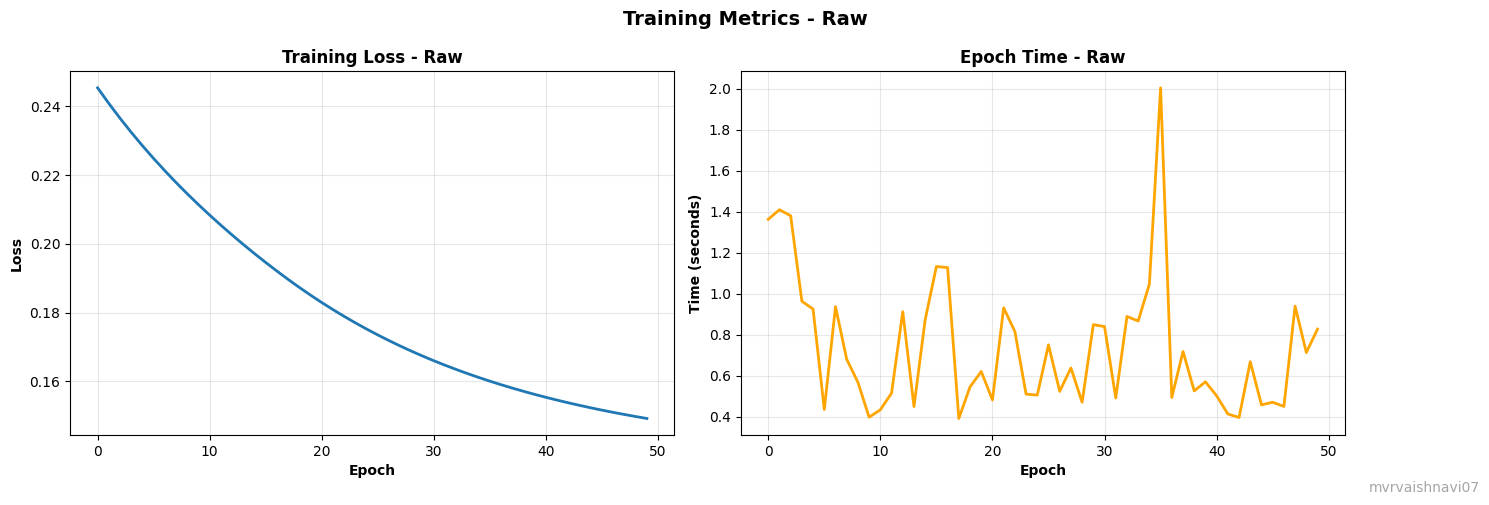


TRAINING: Polynomial_order5

🔄 INITIALIZING MODULAR DATA LOADER
   Image: Q2-20251008T082436Z-1-001/Q2/smiley.png
   Type: Gray
   Method: Polynomial
   Order: 5

✓ Image loaded successfully:
  Path: Q2-20251008T082436Z-1-001/Q2/smiley.png
  Type: Gray
  Size: (256, 256)
  Value range: [0.000, 1.000]
✓ Coordinate grid created:
  Shape: (65536, 2)
  X range: [0.000, 1.000]
  Y range: [0.000, 1.000]
✓ Training data prepared:
  Coordinates shape: (65536, 2)
  Pixel values shape: (65536, 1)
  Total samples: 65536
🎯 Applying Polynomial feature mapping...
   Features generated: (65536, 20)
   Value range: [0.000, 1.000]
🔧 Applying normalization...
   Polynomial features: Applied z-score normalization
   Normalized range: [-1.725, 6.178]
✓ Data loader initialized successfully!
   Final feature shape: (65536, 20)
   Pixel values shape: (65536, 1)

Linear layer created: 20 -> 64, activation: ReLU
Linear layer created: 64 -> 128, activation: ReLU
Linear layer created: 128 -> 128, activation: Re

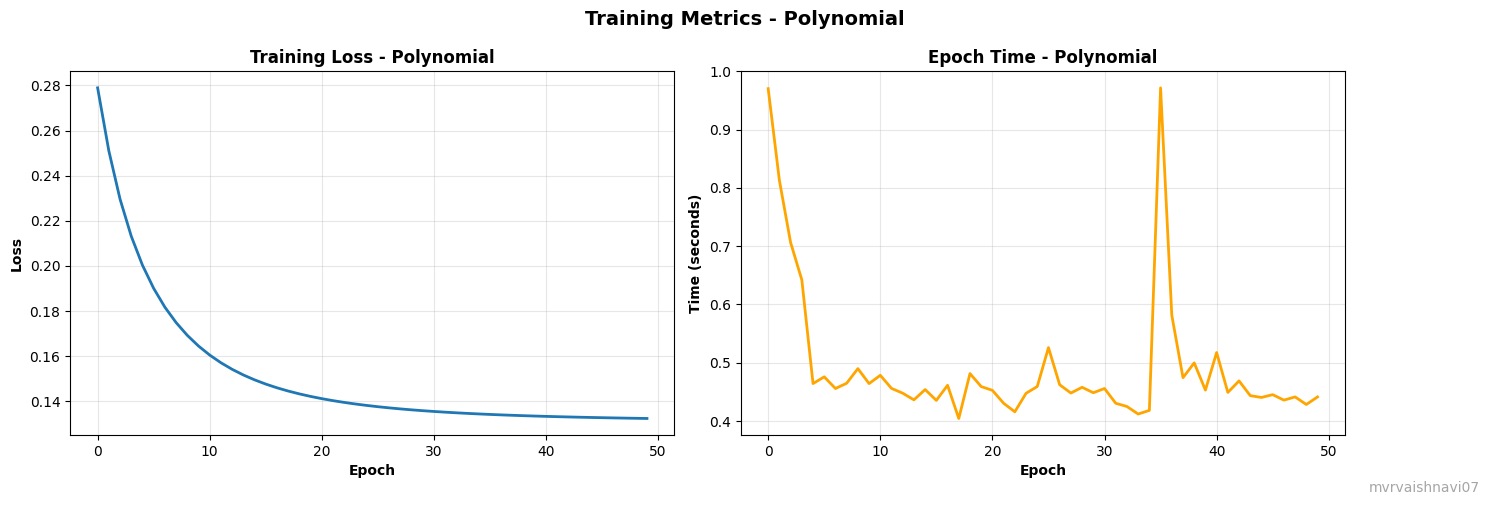


TRAINING: Polynomial_order15

🔄 INITIALIZING MODULAR DATA LOADER
   Image: Q2-20251008T082436Z-1-001/Q2/smiley.png
   Type: Gray
   Method: Polynomial
   Order: 15

✓ Image loaded successfully:
  Path: Q2-20251008T082436Z-1-001/Q2/smiley.png
  Type: Gray
  Size: (256, 256)
  Value range: [0.000, 1.000]
✓ Coordinate grid created:
  Shape: (65536, 2)
  X range: [0.000, 1.000]
  Y range: [0.000, 1.000]
✓ Training data prepared:
  Coordinates shape: (65536, 2)
  Pixel values shape: (65536, 1)
  Total samples: 65536
🎯 Applying Polynomial feature mapping...
   Features generated: (65536, 135)
   Value range: [0.000, 1.000]
🔧 Applying normalization...
   Polynomial features: Applied z-score normalization
   Normalized range: [-1.725, 15.707]
✓ Data loader initialized successfully!
   Final feature shape: (65536, 135)
   Pixel values shape: (65536, 1)

Linear layer created: 135 -> 64, activation: ReLU
Linear layer created: 64 -> 128, activation: ReLU
Linear layer created: 128 -> 128, activati

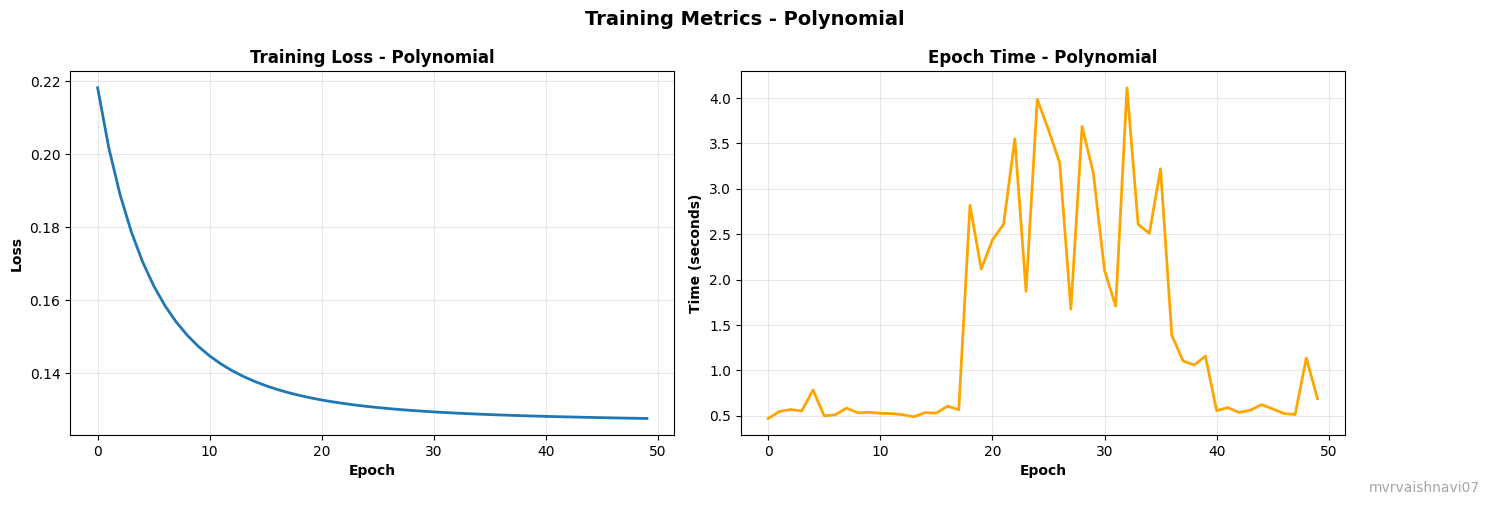


TRAINING: Polynomial_order25

🔄 INITIALIZING MODULAR DATA LOADER
   Image: Q2-20251008T082436Z-1-001/Q2/smiley.png
   Type: Gray
   Method: Polynomial
   Order: 25

✓ Image loaded successfully:
  Path: Q2-20251008T082436Z-1-001/Q2/smiley.png
  Type: Gray
  Size: (256, 256)
  Value range: [0.000, 1.000]
✓ Coordinate grid created:
  Shape: (65536, 2)
  X range: [0.000, 1.000]
  Y range: [0.000, 1.000]
✓ Training data prepared:
  Coordinates shape: (65536, 2)
  Pixel values shape: (65536, 1)
  Total samples: 65536
🎯 Applying Polynomial feature mapping...
   Features generated: (65536, 350)
   Value range: [0.000, 1.000]
🔧 Applying normalization...
   Polynomial features: Applied z-score normalization
   Normalized range: [-1.725, 24.910]
✓ Data loader initialized successfully!
   Final feature shape: (65536, 350)
   Pixel values shape: (65536, 1)

Linear layer created: 350 -> 64, activation: ReLU
Linear layer created: 64 -> 128, activation: ReLU
Linear layer created: 128 -> 128, activati

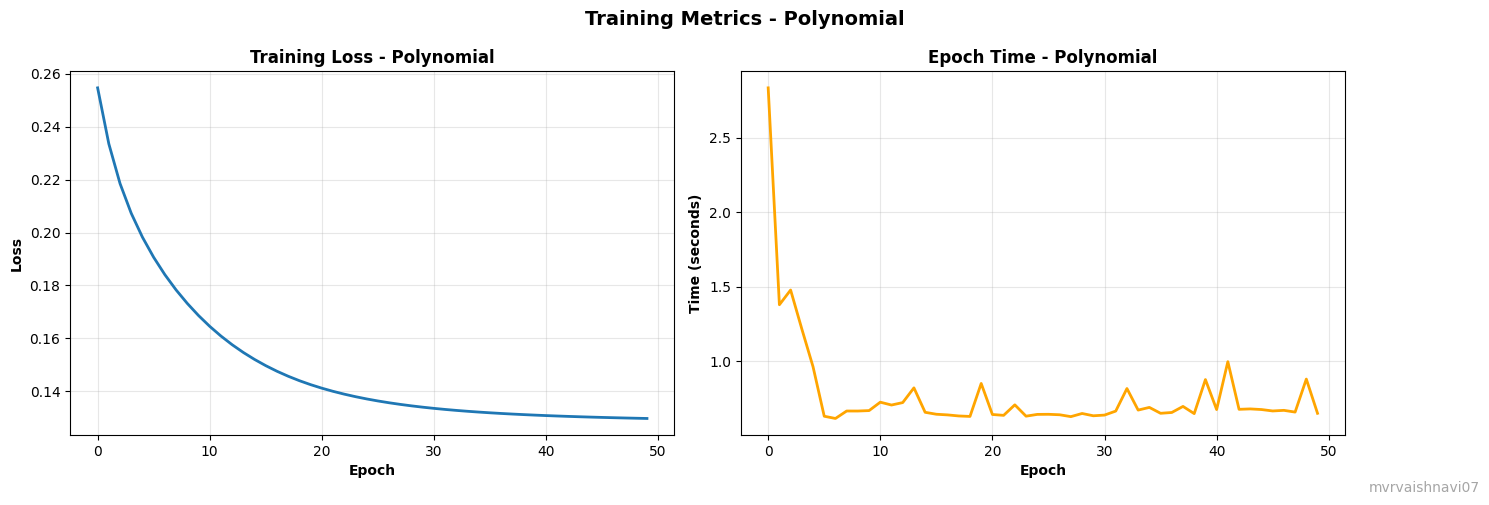


TRAINING: Fourier_freq5

🔄 INITIALIZING MODULAR DATA LOADER
   Image: Q2-20251008T082436Z-1-001/Q2/smiley.png
   Type: Gray
   Method: Fourier
   Frequency: 5

✓ Image loaded successfully:
  Path: Q2-20251008T082436Z-1-001/Q2/smiley.png
  Type: Gray
  Size: (256, 256)
  Value range: [0.000, 1.000]
✓ Coordinate grid created:
  Shape: (65536, 2)
  X range: [0.000, 1.000]
  Y range: [0.000, 1.000]
✓ Training data prepared:
  Coordinates shape: (65536, 2)
  Pixel values shape: (65536, 1)
  Total samples: 65536
🎯 Applying Fourier feature mapping...
   Features generated: (65536, 21)
   Value range: [-1.000, 1.000]
🔧 Applying normalization...
   Fourier features: Applied z-score normalization
   Normalized range: [-1.417, 1.417]
✓ Data loader initialized successfully!
   Final feature shape: (65536, 21)
   Pixel values shape: (65536, 1)

Linear layer created: 21 -> 64, activation: ReLU
Linear layer created: 64 -> 128, activation: ReLU
Linear layer created: 128 -> 128, activation: ReLU
Linea

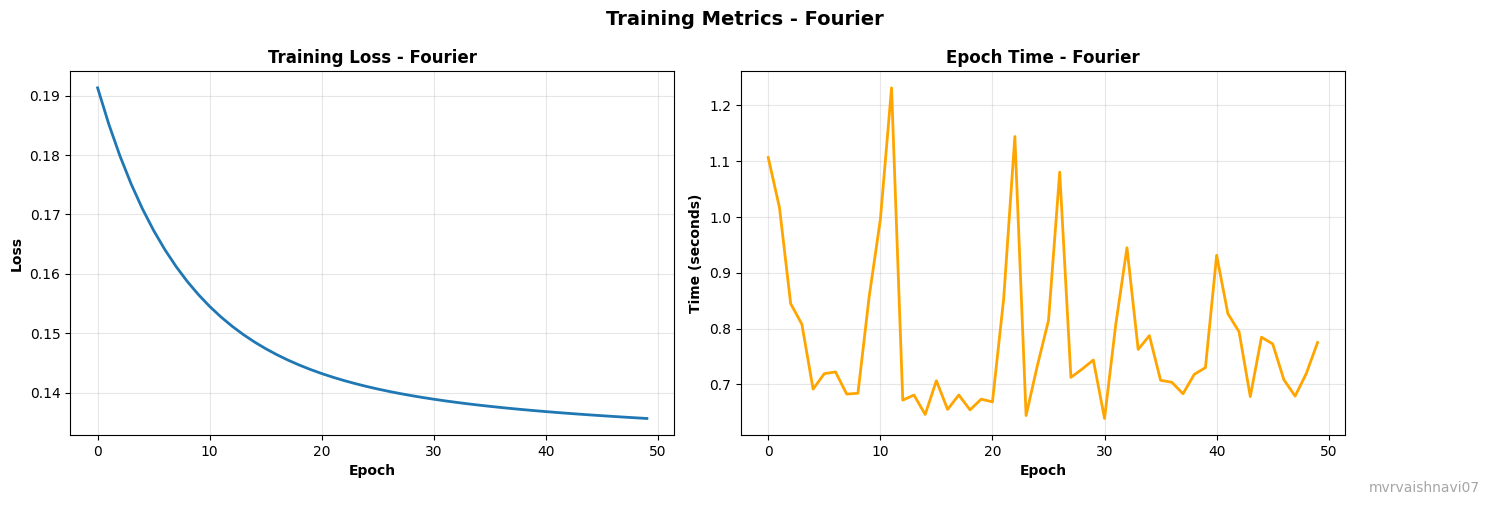


TRAINING: Fourier_freq15

🔄 INITIALIZING MODULAR DATA LOADER
   Image: Q2-20251008T082436Z-1-001/Q2/smiley.png
   Type: Gray
   Method: Fourier
   Frequency: 15

✓ Image loaded successfully:
  Path: Q2-20251008T082436Z-1-001/Q2/smiley.png
  Type: Gray
  Size: (256, 256)
  Value range: [0.000, 1.000]
✓ Coordinate grid created:
  Shape: (65536, 2)
  X range: [0.000, 1.000]
  Y range: [0.000, 1.000]
✓ Training data prepared:
  Coordinates shape: (65536, 2)
  Pixel values shape: (65536, 1)
  Total samples: 65536
🎯 Applying Fourier feature mapping...
   Features generated: (65536, 61)
   Value range: [-1.000, 1.000]
🔧 Applying normalization...
   Fourier features: Applied z-score normalization
   Normalized range: [-1.417, 1.417]
✓ Data loader initialized successfully!
   Final feature shape: (65536, 61)
   Pixel values shape: (65536, 1)

Linear layer created: 61 -> 64, activation: ReLU
Linear layer created: 64 -> 128, activation: ReLU
Linear layer created: 128 -> 128, activation: ReLU
Lin

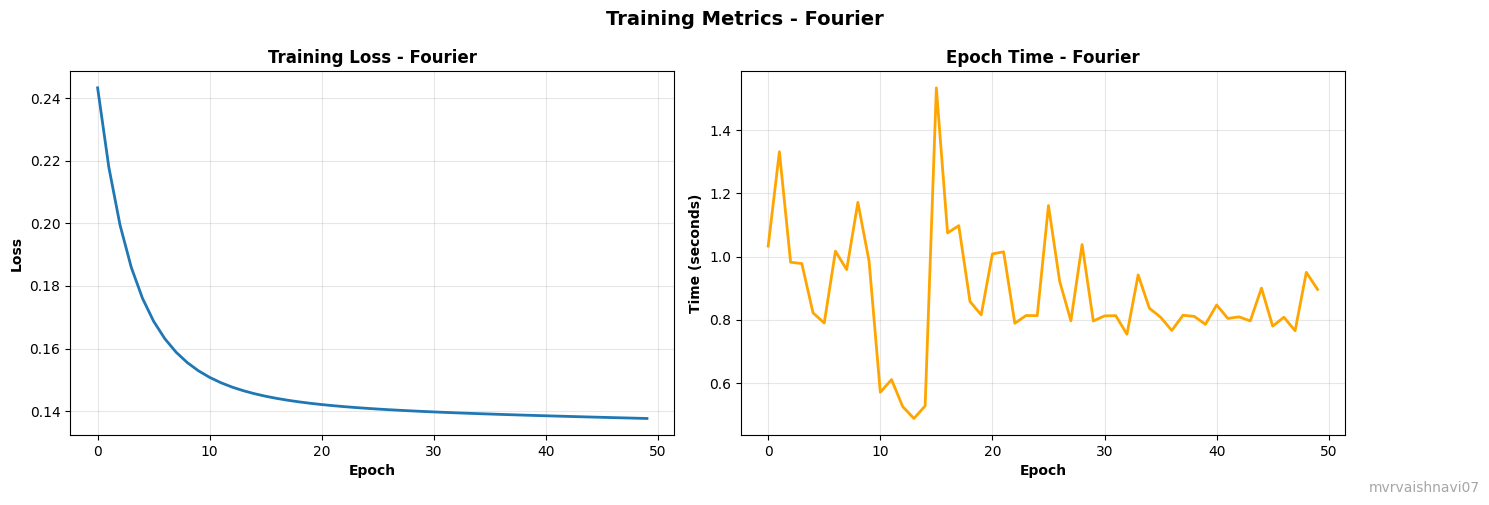


TRAINING: Fourier_freq25

🔄 INITIALIZING MODULAR DATA LOADER
   Image: Q2-20251008T082436Z-1-001/Q2/smiley.png
   Type: Gray
   Method: Fourier
   Frequency: 25

✓ Image loaded successfully:
  Path: Q2-20251008T082436Z-1-001/Q2/smiley.png
  Type: Gray
  Size: (256, 256)
  Value range: [0.000, 1.000]
✓ Coordinate grid created:
  Shape: (65536, 2)
  X range: [0.000, 1.000]
  Y range: [0.000, 1.000]
✓ Training data prepared:
  Coordinates shape: (65536, 2)
  Pixel values shape: (65536, 1)
  Total samples: 65536
🎯 Applying Fourier feature mapping...
   Features generated: (65536, 101)
   Value range: [-1.000, 1.000]
🔧 Applying normalization...
   Fourier features: Applied z-score normalization
   Normalized range: [-1.417, 1.417]
✓ Data loader initialized successfully!
   Final feature shape: (65536, 101)
   Pixel values shape: (65536, 1)

Linear layer created: 101 -> 64, activation: ReLU
Linear layer created: 64 -> 128, activation: ReLU
Linear layer created: 128 -> 128, activation: ReLU


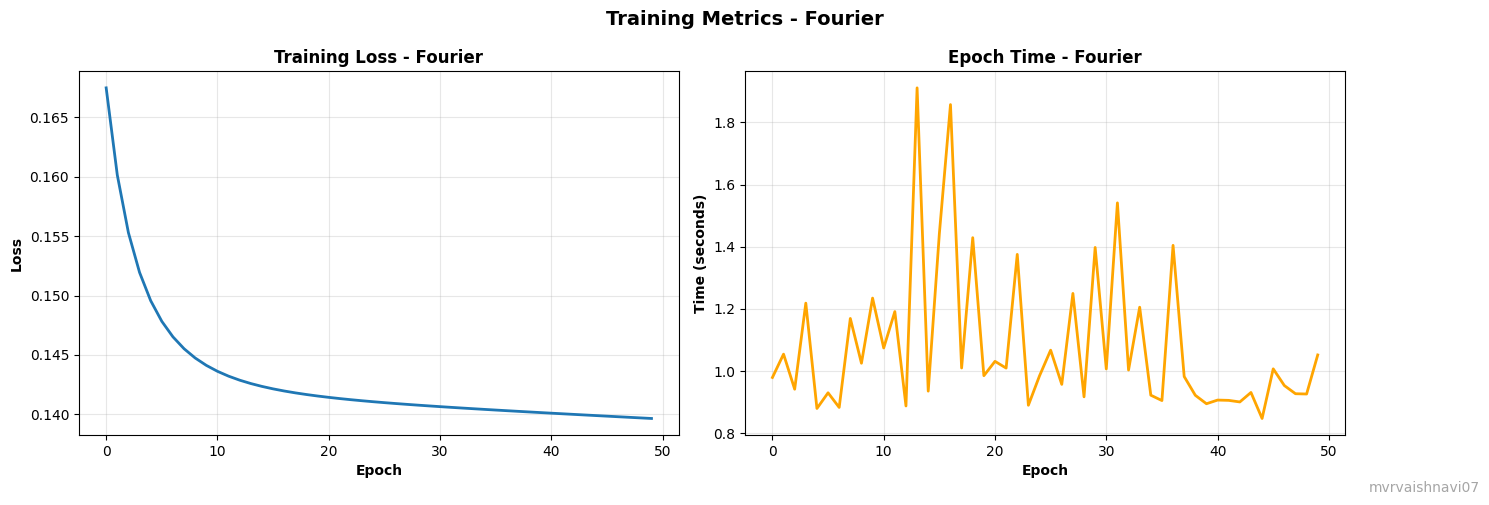


COMPARISON TABLE: FEATURE MAPPING METHODS
                 Method Final Loss Avg Epoch Time (s)  Input Features
                    Raw   0.149193              0.737               2
 Polynomial (order=5.0)   0.132438              0.493              20
Polynomial (order=15.0)   0.127678              1.441             135
Polynomial (order=25.0)   0.129656              0.779             350
     Fourier (freq=5.0)   0.135637              0.780              21
    Fourier (freq=15.0)   0.137680              0.877              61
    Fourier (freq=25.0)   0.139658              1.082             101


Creating comparison GIF...
🎬 Creating comparison GIF...


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x75aded20e900>>
Traceback (most recent call last):
  File "/home/vaishnavimiryala/Desktop/Sem-5/SMAI/ASSINGNMENTS/A3-V3/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 797, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

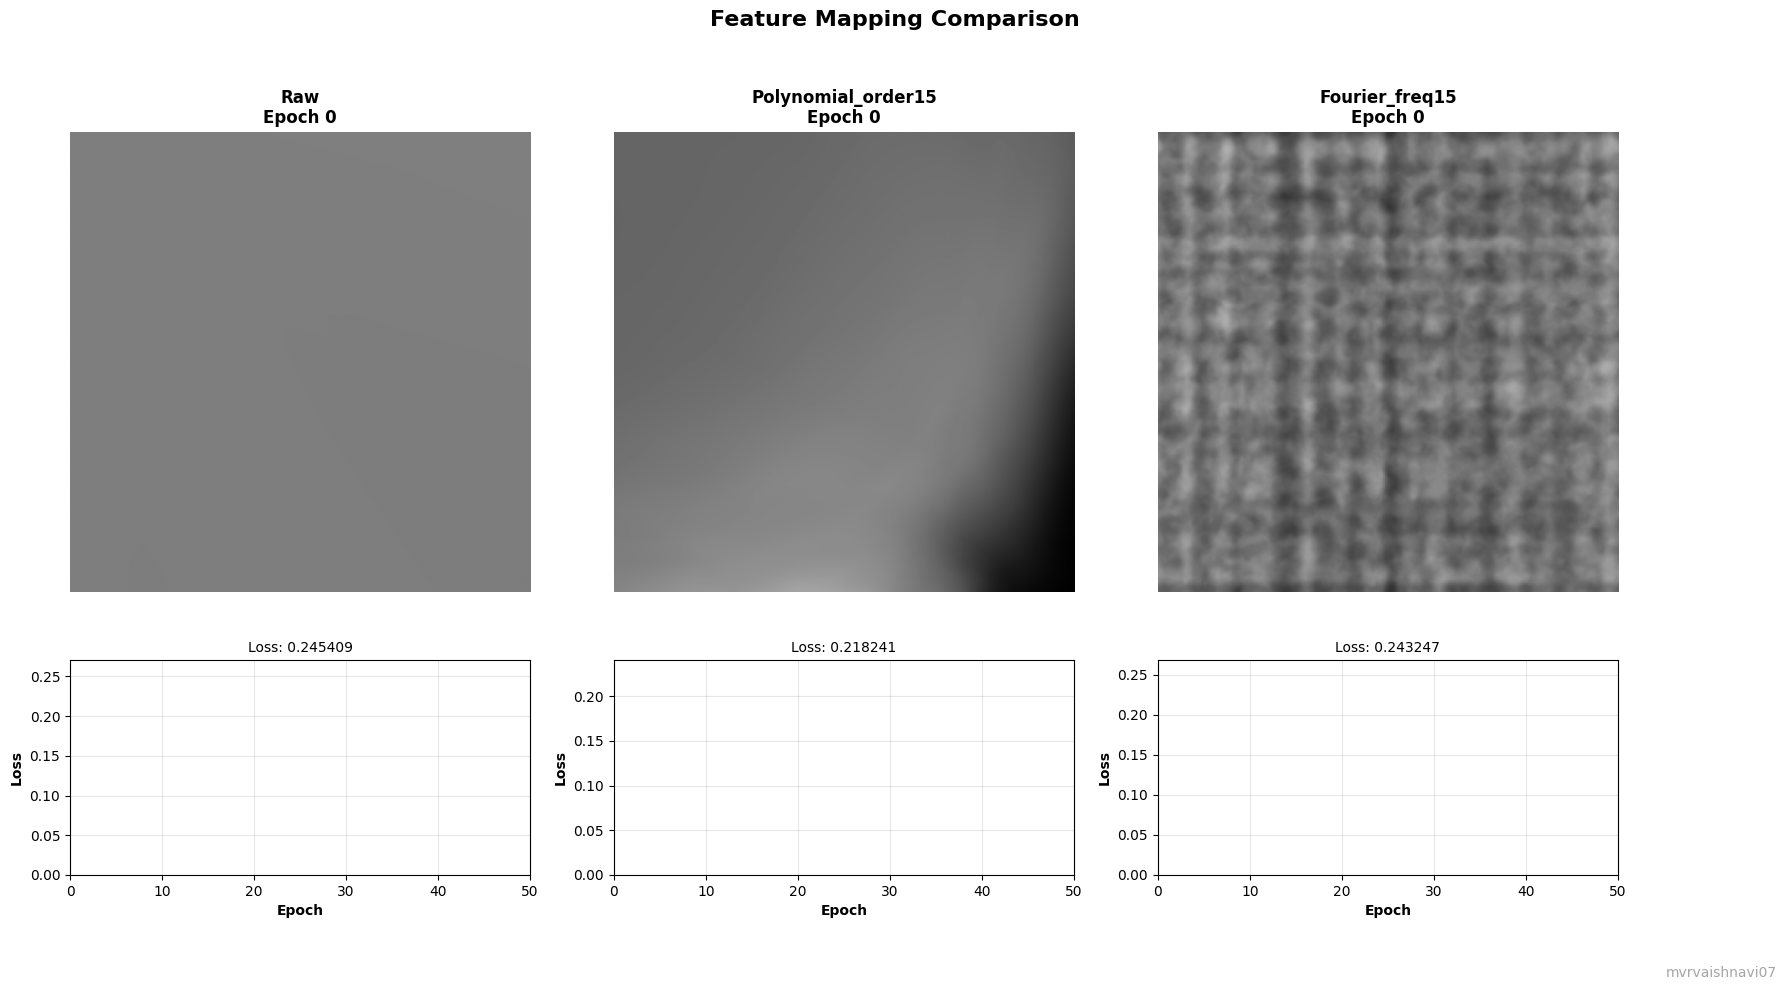

In [15]:
# ==========================================
# PART 2.4: TRAINING AND COMPARISON [4 MARKS]
# ==========================================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
from datetime import datetime
import pandas as pd

class ImageReconstructionTrainer:
    """
    Trainer class for coordinate-based image reconstruction with different feature mappings.
    Tracks metrics, saves epoch images, and generates comparison visualizations.
    """
    
    def __init__(self, model, dataloader, output_dir="output", username="mvrvaishnavi07"):
        """
        Initialize trainer.
        
        Args:
            model: Neural network model
            dataloader: ModularDataLoader instance
            output_dir: Directory to save outputs
            username: Username for watermarks
        """
        self.model = model
        self.dataloader = dataloader
        self.output_dir = output_dir
        self.username = username
        
        # Get data info
        self.info = dataloader.get_info()
        self.features, self.pixel_values = dataloader.get_data()
        
        # Create subdirectory for this experiment
        method_name = f"{self.info['method']}"
        if self.info['method'] == "Polynomial":
            method_name += f"_order{self.info['order']}"
        elif self.info['method'] == "Fourier":
            method_name += f"_freq{self.info['freq']}"
        
        self.experiment_dir = os.path.join(output_dir, method_name)
        os.makedirs(self.experiment_dir, exist_ok=True)
        
        # Training history
        self.epoch_losses = []
        self.epoch_times = []
        self.epoch_images = []
        
        print(f"✓ Trainer initialized:")
        print(f"   Method: {self.info['method']}")
        print(f"   Output directory: {self.experiment_dir}")
        print(f"   Training samples: {len(self.features)}")
        print()
    
    def train(self, num_epochs, batch_size=1024, save_every=1):
        """
        Train the model for specified epochs.
        
        Args:
            num_epochs (int): Number of training epochs
            batch_size (int): Batch size for training
            save_every (int): Save image every N epochs
            
        Returns:
            dict: Training summary
        """
        print(f"🚀 STARTING TRAINING")
        print(f"   Epochs: {num_epochs}")
        print(f"   Batch size: {batch_size}")
        print("="*50)
        
        n_samples = len(self.features)
        n_batches = (n_samples + batch_size - 1) // batch_size
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            epoch_loss = 0.0
            
            # Shuffle data
            indices = np.random.permutation(n_samples)
            
            # Mini-batch training
            for batch_idx in range(n_batches):
                start_idx = batch_idx * batch_size
                end_idx = min((batch_idx + 1) * batch_size, n_samples)
                batch_indices = indices[start_idx:end_idx]
                
                batch_features = self.features[batch_indices]
                batch_pixels = self.pixel_values[batch_indices]
                
                # Training step
                loss = self.model.train_step(batch_features, batch_pixels)
                epoch_loss += loss * len(batch_indices)
            
            # Update weights after all batches
            self.model.update_weights()
            
            # Calculate average epoch loss
            avg_epoch_loss = epoch_loss / n_samples
            epoch_time = time.time() - epoch_start
            
            self.epoch_losses.append(avg_epoch_loss)
            self.epoch_times.append(epoch_time)
            
            # Save epoch image
            if epoch % save_every == 0 or epoch == num_epochs - 1:
                reconstructed = self.reconstruct_image()
                self.epoch_images.append(reconstructed)
                
                # Save to disk
                self._save_epoch_image(reconstructed, epoch)
            
            # Print progress
            if epoch % 10 == 0 or epoch == num_epochs - 1:
                print(f"   Epoch {epoch+1:3d}/{num_epochs} | "
                      f"Loss: {avg_epoch_loss:.6f} | "
                      f"Time: {epoch_time:.2f}s")
        
        total_time = time.time() - start_time
        
        print("="*50)
        print(f"✓ TRAINING COMPLETE")
        print(f"   Total time: {total_time:.2f}s")
        print(f"   Average epoch time: {np.mean(self.epoch_times):.2f}s")
        print(f"   Final loss: {self.epoch_losses[-1]:.6f}")
        print()
        
        return {
            'method': self.info['method'],
            'order': self.info.get('order'),
            'freq': self.info.get('freq'),
            'final_loss': self.epoch_losses[-1],
            'avg_epoch_time': np.mean(self.epoch_times),
            'total_time': total_time,
            'num_epochs': num_epochs,
            'input_features': self.info['feature_shape'][1]
        }
    
    def reconstruct_image(self):
        """
        Reconstruct the full image using current model.
        
        Returns:
            numpy.ndarray: Reconstructed image
        """
        # Predict all pixels
        predictions = self.model.predict(self.features)
        
        # Reshape to image
        img_shape = self.info['image_shape']
        if len(img_shape) == 3:  # RGB
            reconstructed = predictions.reshape(img_shape)
        else:  # Grayscale
            reconstructed = predictions.reshape(img_shape[0], img_shape[1])
        
        # Clip to valid range
        reconstructed = np.clip(reconstructed, 0, 1)
        
        return reconstructed
    
    def _save_epoch_image(self, image, epoch):
        """Save reconstructed image for this epoch."""
        filename = f"epoch_{epoch:04d}.png"
        filepath = os.path.join(self.experiment_dir, filename)
        
        # Convert to uint8
        img_uint8 = (image * 255).astype(np.uint8)
        
        # Save
        if len(image.shape) == 2:  # Grayscale
            Image.fromarray(img_uint8, mode='L').save(filepath)
        else:  # RGB
            Image.fromarray(img_uint8, mode='RGB').save(filepath)
    
    def get_training_summary(self):
        """Get summary of training."""
        return {
            'epoch_losses': self.epoch_losses,
            'epoch_times': self.epoch_times,
            'total_epochs': len(self.epoch_losses),
            'experiment_dir': self.experiment_dir
        }
    
    def plot_training_curve(self):
        """Plot training loss curve."""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss curve
        axes[0].plot(self.epoch_losses, linewidth=2)
        axes[0].set_xlabel('Epoch', fontweight='bold')
        axes[0].set_ylabel('Loss', fontweight='bold')
        axes[0].set_title(f'Training Loss - {self.info["method"]}', fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Time per epoch
        axes[1].plot(self.epoch_times, linewidth=2, color='orange')
        axes[1].set_xlabel('Epoch', fontweight='bold')
        axes[1].set_ylabel('Time (seconds)', fontweight='bold')
        axes[1].set_title(f'Epoch Time - {self.info["method"]}', fontweight='bold')
        axes[1].grid(True, alpha=0.3)
        
        plt.suptitle(f'Training Metrics - {self.info["method"]}', 
                    fontsize=14, fontweight='bold')
        
        # Add username watermark
        plt.text(0.99, 0.01, self.username,
                ha='right', va='bottom', transform=fig.transFigure,
                fontsize=10, color='gray', alpha=0.7)
        
        plt.tight_layout()
        plt.show()


class ComparisonAnalyzer:
    """
    Analyzer class for comparing different feature mapping methods.
    Creates tables, visualizations, and GIFs.
    """
    
    def __init__(self, username="mvrvaishnavi07"):
        """Initialize analyzer."""
        self.username = username
        self.results = []
    
    def add_result(self, result_dict):
        """Add a training result."""
        self.results.append(result_dict)
    
    def create_comparison_table(self):
        """
        Create comparison table of all results.
        
        Returns:
            pandas.DataFrame: Comparison table
        """
        df = pd.DataFrame(self.results)
        
        # Format columns
        if 'final_loss' in df.columns:
            df['Final Loss'] = df['final_loss'].map('{:.6f}'.format)
        if 'avg_epoch_time' in df.columns:
            df['Avg Epoch Time (s)'] = df['avg_epoch_time'].map('{:.3f}'.format)
        if 'input_features' in df.columns:
            df['Input Features'] = df['input_features'].astype(int)
        
        # Create display columns
        display_df = pd.DataFrame({
            'Method': df.apply(lambda row: self._format_method_name(row), axis=1),
            'Final Loss': df['Final Loss'],
            'Avg Epoch Time (s)': df['Avg Epoch Time (s)'],
            'Input Features': df['Input Features']
        })
        
        return display_df
    
    def _format_method_name(self, row):
        """Format method name with parameters."""
        if row['method'] == 'Raw':
            return 'Raw'
        elif row['method'] == 'Polynomial':
            return f"Polynomial (order={row['order']})"
        elif row['method'] == 'Fourier':
            return f"Fourier (freq={row['freq']})"
        return row['method']
    
    def print_comparison_table(self):
        """Print formatted comparison table."""
        df = self.create_comparison_table()
        print("\n" + "="*80)
        print("COMPARISON TABLE: FEATURE MAPPING METHODS")
        print("="*80)
        print(df.to_string(index=False))
        print("="*80 + "\n")
    
    def create_gif(self, trainers_dict, output_path, fps=5):
        """
        Create side-by-side GIF comparing different methods.
        
        Args:
            trainers_dict (dict): Dictionary of {method_name: trainer}
            output_path (str): Path to save GIF
            fps (int): Frames per second
        """
        print(f"🎬 Creating comparison GIF...")
        
        n_methods = len(trainers_dict)
        method_names = list(trainers_dict.keys())
        
        # Get minimum number of epochs across all methods
        min_epochs = min(len(trainers_dict[name].epoch_images) 
                        for name in method_names)
        
        frames = []
        
        for epoch_idx in range(min_epochs):
            # Create figure for this frame
            fig, axes = plt.subplots(2, n_methods, figsize=(6*n_methods, 10),
                                    gridspec_kw={'height_ratios': [3, 1]})
            
            if n_methods == 1:
                axes = axes.reshape(-1, 1)
            
            for col_idx, method_name in enumerate(method_names):
                trainer = trainers_dict[method_name]
                
                # Plot image
                img = trainer.epoch_images[epoch_idx]
                if len(img.shape) == 2:  # Grayscale
                    axes[0, col_idx].imshow(img, cmap='gray', vmin=0, vmax=1)
                else:  # RGB
                    axes[0, col_idx].imshow(img)
                
                # Calculate actual epoch number
                save_every = len(trainer.epoch_losses) // len(trainer.epoch_images)
                actual_epoch = epoch_idx * save_every
                
                axes[0, col_idx].set_title(
                    f'{method_name}\nEpoch {actual_epoch}',
                    fontweight='bold', fontsize=12
                )
                axes[0, col_idx].axis('off')
                
                # Plot loss curve up to this epoch
                epochs_so_far = actual_epoch + 1
                losses = trainer.epoch_losses[:epochs_so_far]
                axes[1, col_idx].plot(losses, linewidth=2, color='blue')
                axes[1, col_idx].set_xlabel('Epoch', fontweight='bold')
                axes[1, col_idx].set_ylabel('Loss', fontweight='bold')
                axes[1, col_idx].set_title(f'Loss: {losses[-1]:.6f}', fontsize=10)
                axes[1, col_idx].grid(True, alpha=0.3)
                axes[1, col_idx].set_xlim(0, len(trainer.epoch_losses))
                axes[1, col_idx].set_ylim(0, max(trainer.epoch_losses) * 1.1)
            
            plt.suptitle('Feature Mapping Comparison', 
                        fontsize=16, fontweight='bold')
            
            # Add username watermark
            plt.text(0.99, 0.01, self.username,
                    ha='right', va='bottom', transform=fig.transFigure,
                    fontsize=10, color='gray', alpha=0.7)
            
            plt.tight_layout()
            
            # Convert to image
            fig.canvas.draw()
            image = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
            image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
            frames.append(Image.fromarray(image))
            
            plt.close(fig)
        
        # Save GIF
        duration = int(1000 / fps)  # milliseconds per frame
        frames[0].save(
            output_path,
            save_all=True,
            append_images=frames[1:],
            duration=duration,
            loop=0
        )
        
        print(f"✓ GIF saved to: {output_path}")
        print(f"   Frames: {len(frames)}")
        print(f"   Duration: {len(frames) / fps:.1f} seconds")


# ==========================================
# MAIN TRAINING SCRIPT FOR PART 2.4
# ==========================================

def train_all_configurations(image_path, image_type, num_epochs, 
                            output_dir="output_2_4"):
    """
    Train all feature mapping configurations and generate comparison.
    
    Args:
        image_path (str): Path to image
        image_type (str): "RGB" or "Gray"
        num_epochs (int): Number of epochs to train
        output_dir (str): Output directory
    """
    print("="*80)
    print(f"TRAINING ALL CONFIGURATIONS FOR IMAGE: {image_path}")
    print("="*80)
    
    # Determine output channels
    output_channels = 1 if image_type == "Gray" else 3
    
    # Configuration lists
    configurations = []
    
    # 1. Raw baseline
    configurations.append({
        'method': 'Raw',
        'order': None,
        'freq': None
    })
    
    # 2. Polynomial with different orders
    for order in [5, 15, 25]:
        configurations.append({
            'method': 'Polynomial',
            'order': order,
            'freq': None
        })
    
    # 3. Fourier with different frequencies
    for freq in [5, 15, 25]:
        configurations.append({
            'method': 'Fourier',
            'order': None,
            'freq': freq
        })
    
    # Storage for results
    analyzer = ComparisonAnalyzer()
    all_trainers = {}
    
    # Train each configuration
    for config in configurations:
        print(f"\n{'='*80}")
        config_name = config['method']
        if config['method'] == 'Polynomial':
            config_name += f"_order{config['order']}"
        elif config['method'] == 'Fourier':
            config_name += f"_freq{config['freq']}"
        print(f"TRAINING: {config_name}")
        print(f"{'='*80}\n")
        
        # Create dataloader
        dataloader = ModularDataLoader(
            img_path=image_path,
            image_type=image_type,
            method=config['method'],
            order=config['order'],
            freq=config['freq'],
            normalize=True
        )
        
        # Get input size
        features, _ = dataloader.get_data()
        input_size = features.shape[1]
        
        # Create model (same architecture for all)
        model = Model(
            layers=[
                Linear(input_size, 64, activation=ReLU()),
                Linear(64, 128, activation=ReLU()),
                Linear(128, 128, activation=ReLU()),
                Linear(128, output_channels, activation=Sigmoid())
            ],
            loss_function=MSELoss(),
            learning_rate=0.001
        )
        
        # Create trainer
        trainer = ImageReconstructionTrainer(
            model=model,
            dataloader=dataloader,
            output_dir=output_dir
        )
        
        # Train
        result = trainer.train(num_epochs=num_epochs, batch_size=1024, save_every=1)
        
        # Store results
        analyzer.add_result(result)
        all_trainers[config_name] = trainer
        
        # Plot training curve
        trainer.plot_training_curve()
    
    # Print comparison table
    analyzer.print_comparison_table()
    
    # Create GIF for selected configurations
    print("\nCreating comparison GIF...")
    selected_trainers = {
        'Raw': all_trainers['Raw'],
        'Polynomial_order15': all_trainers['Polynomial_order15'],
        'Fourier_freq15': all_trainers['Fourier_freq15']
    }
    
    gif_path = os.path.join(output_dir, "comparison.gif")
    analyzer.create_gif(selected_trainers, gif_path, fps=5)
    
    print("\n" + "="*80)
    print("✓ ALL TRAINING COMPLETE")
    print("="*80)
    
    return analyzer, all_trainers


# ==========================================
# EXECUTION FOR SMILEY IMAGE
# ==========================================

print("\n" + "="*80)
print("PART 2.4: TRAINING SMILEY IMAGE")
print("="*80)

if 'smiley_path' in locals():
    analyzer_smiley, trainers_smiley = train_all_configurations(
        image_path=smiley_path,
        image_type="Gray",
        num_epochs=50,
        output_dir="output_2_4_smiley"
    )

# ==========================================
# EXECUTION FOR CAT IMAGE
# ==========================================

print("\n" + "="*80)
print("PART 2.4: TRAINING CAT IMAGE")
print("="*80)

if 'cat_path' in locals():
    analyzer_cat, trainers_cat = train_all_configurations(
        image_path=cat_path,
        image_type="RGB",
        num_epochs=150,
        output_dir="output_2_4_cat"
    )

print("\n✓ Part 2.4 Complete!")

In [ ]:
# ==========================================
# PART 2.5: RECONSTRUCTION ON BLURRED IMAGES [10 MARKS]
# ==========================================

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob

class BlurredImageExperiment:
    """
    Experiment class for analyzing reconstruction performance on blurred images.
    
    This experiment tests the key insight from Tancik et al.:
    - High-frequency details (sharp edges) are lost as blur increases
    - Fourier features excel when high-frequency components are present
    - As images become more blurred (low-frequency), the advantage diminishes
    """
    
    def __init__(self, blur_dir, method_configs, username="mvrvaishnavi07"):
        """
        Initialize blur experiment.
        
        Args:
            blur_dir (str): Directory containing blur_0.jpg to blur_10.jpg
            method_configs (list): List of dicts with 'name', 'method', and params
            username (str): Username for watermarks
        """
        self.blur_dir = blur_dir
        self.method_configs = method_configs
        self.username = username
        
        # Storage for results
        self.results = {config['name']: [] for config in method_configs}
        self.reconstructed_images = {config['name']: [] for config in method_configs}
        
        # Load blur levels
        self.blur_levels = self._load_blur_levels()
        
        print(f"✓ Blur Experiment Initialized")
        print(f"   Blur directory: {blur_dir}")
        print(f"   Blur levels found: {len(self.blur_levels)}")
        print(f"   Methods to compare: {[c['name'] for c in method_configs]}")
        print()
    
    def _load_blur_levels(self):
        """Load and sort blur level images."""
        pattern = os.path.join(self.blur_dir, "blur_*.jpg")
        files = sorted(glob.glob(pattern))
        
        if len(files) == 0:
            raise ValueError(f"No blur images found in {self.blur_dir}")
        
        blur_levels = []
        for f in files:
            # Extract blur level from filename
            basename = os.path.basename(f)
            level = int(basename.split('_')[1].split('.')[0])
            blur_levels.append({
                'level': level,
                'path': f
            })
        
        return sorted(blur_levels, key=lambda x: x['level'])
    
    def run_experiment(self, max_epochs=100, patience=10, min_delta=1e-5):
        """
        Run the full experiment across all blur levels and methods.
        
        Args:
            max_epochs (int): Maximum epochs per image
            patience (int): Early stopping patience
            min_delta (float): Minimum improvement for early stopping
        """
        print("="*80)
        print("STARTING BLUR RECONSTRUCTION EXPERIMENT")
        print("="*80)
        
        for blur_info in self.blur_levels:
            level = blur_info['level']
            path = blur_info['path']
            
            print(f"\n{'='*80}")
            print(f"BLUR LEVEL {level}")
            print(f"{'='*80}\n")
            
            for config in self.method_configs:
                method_name = config['name']
                
                print(f"   Training {method_name}...")
                
                # Create dataloader
                dataloader = ModularDataLoader(
                    img_path=path,
                    image_type="RGB",
                    method=config['method'],
                    order=config.get('order'),
                    freq=config.get('freq'),
                    normalize=True
                )
                
                # Get input size
                features, pixel_values = dataloader.get_data()
                input_size = features.shape[1]
                
                # Create model
                model = Model(
                    layers=[
                        Linear(input_size, 64, activation=ReLU()),
                        Linear(64, 128, activation=ReLU()),
                        Linear(128, 128, activation=ReLU()),
                        Linear(128, 3, activation=Sigmoid())
                    ],
                    loss_function=MSELoss(),
                    learning_rate=0.001
                )
                
                # Train with early stopping
                result = self._train_with_early_stopping(
                    model=model,
                    features=features,
                    pixel_values=pixel_values,
                    max_epochs=max_epochs,
                    patience=patience,
                    min_delta=min_delta
                )
                
                # Reconstruct final image
                predictions = model.predict(features)
                img_shape = dataloader.info['image_shape']
                reconstructed = predictions.reshape(img_shape)
                reconstructed = np.clip(reconstructed, 0, 1)
                
                # Store results
                self.results[method_name].append({
                    'blur_level': level,
                    'final_loss': result['final_loss'],
                    'epochs_trained': result['epochs_trained'],
                    'stopped_early': result['stopped_early']
                })
                
                self.reconstructed_images[method_name].append({
                    'blur_level': level,
                    'image': reconstructed
                })
                
                print(f"      ✓ Loss: {result['final_loss']:.6f}, "
                      f"Epochs: {result['epochs_trained']}, "
                      f"Early stop: {result['stopped_early']}")
        
        print("\n" + "="*80)
        print("✓ EXPERIMENT COMPLETE")
        print("="*80)
    
    def _train_with_early_stopping(self, model, features, pixel_values, 
                                   max_epochs, patience, min_delta):
        """
        Train model with early stopping.
        
        Args:
            model: Neural network model
            features: Input features
            pixel_values: Target pixel values
            max_epochs: Maximum epochs
            patience: Patience for early stopping
            min_delta: Minimum improvement threshold
            
        Returns:
            dict: Training results
        """
        n_samples = len(features)
        batch_size = 1024
        n_batches = (n_samples + batch_size - 1) // batch_size
        
        best_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(max_epochs):
            epoch_loss = 0.0
            
            # Shuffle data
            indices = np.random.permutation(n_samples)
            
            # Mini-batch training
            for batch_idx in range(n_batches):
                start_idx = batch_idx * batch_size
                end_idx = min((batch_idx + 1) * batch_size, n_samples)
                batch_indices = indices[start_idx:end_idx]
                
                batch_features = features[batch_indices]
                batch_pixels = pixel_values[batch_indices]
                
                # Training step
                loss = model.train_step(batch_features, batch_pixels)
                epoch_loss += loss * len(batch_indices)
            
            # Update weights
            model.update_weights()
            
            # Calculate average loss
            avg_loss = epoch_loss / n_samples
            
            # Early stopping check
            if best_loss - avg_loss > min_delta:
                best_loss = avg_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                return {
                    'final_loss': best_loss,
                    'epochs_trained': epoch + 1,
                    'stopped_early': True
                }
        
        return {
            'final_loss': avg_loss,
            'epochs_trained': max_epochs,
            'stopped_early': False
        }
    
    def plot_loss_comparison(self, log_scale=False):
        """
        Plot reconstruction loss across blur levels.
        
        Args:
            log_scale (bool): Use logarithmic y-axis
        """
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        for method_name, results in self.results.items():
            blur_levels = [r['blur_level'] for r in results]
            losses = [r['final_loss'] for r in results]
            
            ax.plot(blur_levels, losses, marker='o', linewidth=2, 
                   markersize=8, label=method_name)
        
        ax.set_xlabel('Blur Level (σ)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Reconstruction Loss', fontsize=12, fontweight='bold')
        
        title = 'Reconstruction Loss vs Blur Level'
        if log_scale:
            ax.set_ysc